# Federato RiskOps Platform Optimization Challenge

### Importing required libraries

In [1]:
%%time
import ast
import ijson
import json
import glob
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
import numpy as new_export
import matplotlib.pyplot as plt
from collections import Counter
from matplotlib.ticker import MaxNLocator

CPU times: user 1.43 s, sys: 697 ms, total: 2.12 s
Wall time: 699 ms


### Given code to extract and turn .json files into .csv

In [ ]:
#file year 
year = 2025
file_path = f"new_amplitude_export_{year}.json"

#non-empty columns
columns_keep = [
    "$insert_id",
    "amplitude_id",
    "app",
    "city",
    "client_event_time",
    "client_upload_time",
    "country",
    "data",
    "data_type",
    "device_family",
    "device_id",
    "device_type",
    "dma",
    "event_id",
    "event_properties",
    "event_time",
    "event_type",
    "language",
    "library",
    "os_name",
    "os_version",
    "platform",
    "processed_time",
    "region",
    "server_received_time",
    "server_upload_time",
    "session_id",
    "user_id",
    "user_properties",
    "uuid",
]
path = Path(f"{year}_csv")
if not path.exists():
    path.mkdir(parents=True, exist_ok=True)
#use ijson to read the json files efficiently in memory
with open(file_path, "r") as f:
    objects = ijson.items(f, "item") #creates a generator object
    
    batch_size = 100000 #can be updated, currently saves per batches of 100,000
    chunk = []
    count = 0 #used to index batch file
    for obj in objects:
        chunk.append(obj)
        if len(chunk) >= batch_size:
            df = pd.DataFrame(chunk)
            output_csv = f"{year}_csv/{file_path.split('.')[0]}_chunk_{count*batch_size}_{(count+1)*batch_size}.csv"
            df = df[columns_keep] #remove empty columns
            df.to_csv(output_csv, index=False)
            count += 1
            chunk = []

    if chunk: #process remaining data if any
        output_csv = f"{year}_csv/{file_path.split('.')[0]}_chunk_{count*batch_size}_{(count+1)*batch_size}.csv"
        df = pd.DataFrame(chunk)
        df = df[columns_keep]
        df.to_csv(output_csv, index=False)


In [ ]:
#file chunk 
part = 1
file_path = f"new_export/amplitude_export_chunk_{part}_anonymized.json"

#non-empty columns
columns_keep = [
    "$insert_id",
    "amplitude_id",
    "app",
    "city",
    "client_event_time",
    "client_upload_time",
    "country",
    "data",
    "data_type",
    "device_family",
    "device_id",
    "device_type",
    "dma",
    "event_id",
    "event_properties",
    "event_time",
    "event_type",
    "language",
    "library",
    "os_name",
    "os_version",
    "platform",
    "processed_time",
    "region",
    "server_received_time",
    "server_upload_time",
    "session_id",
    "user_id",
    "user_properties",
    "uuid",
]

path = Path(f"{part}_csv")
if not path.exists():
    path.mkdir(parents=True, exist_ok=True)

#use ijson to read the json files efficiently in memory
with open(file_path, "r") as f:
    objects = ijson.items(f, "item") #creates a generator object
    
    batch_size = 100000 #can be updated, currently saves per batches of 100,000
    chunk = []
    count = 0 #used to index batch file
    for obj in objects:
        chunk.append(obj)
        if len(chunk) >= batch_size:
            df = pd.DataFrame(chunk)
            output_csv = f"{part}_csv/{file_path.split('/')[1].split('.')[0]}_subchunk_{count*batch_size}_{(count+1)*batch_size}.csv"
            df = df[columns_keep] #remove empty columns
            df.to_csv(output_csv, index=False)
            count += 1
            chunk = []

    if chunk: #process remaining data if any
        output_csv = f"{part}_csv/{file_path.split('/')[1].split('.')[0]}_subchunk_{count*batch_size}_{(count+1)*batch_size}.csv"
        df = pd.DataFrame(chunk)
        print(df.shape)
        df = df[columns_keep]
        print(df.shape)
        df.to_csv(output_csv, index=False)


# Examining Data
### Type of data, columns, etc.
Specifically examining amplitude_export_chunk_1_anonymized_subchunk_0_100000.csv as found in 1_csv folder.

In [2]:
df = pd.read_csv('1_csv/amplitude_export_chunk_1_anonymized_subchunk_0_100000.csv')

df.head()

,$insert_id,amplitude_id,app,city,client_event_time,client_upload_time,country,data,data_type,device_family,...,os_version,platform,processed_time,region,server_received_time,server_upload_time,session_id,user_id,user_properties,uuid
0,b5aa91c6-ac17-4bfe-8def-df50869540b0,857540442426,591532,Covington,2024-06-14 23:06:34.898000,2024-06-14 23:06:35.998000,United States,"{'path': '/2/httpapi', 'group_first_event': {}...",event,Windows,...,125,Web,2024-06-14 23:06:36.809000,Georgia,2024-06-14 23:06:35.998000,2024-06-14 23:06:36.007000,1718399623706,01708ccf-437b-44ed-b5a0-2fed8f7761d3,"{'initial_utm_medium': 'EMPTY', 'initial_refer...",f10e3860-18f7-4e43-93d9-29bda5edb636
1,dc6c6dd1-8c20-4faf-8996-5fc532120b81,857540442426,591532,Covington,2024-06-14 23:06:34.926000,2024-06-14 23:06:35.998000,United States,"{'path': '/2/httpapi', 'group_first_event': {}...",event,Windows,...,125,Web,2024-06-14 23:06:36.809000,Georgia,2024-06-14 23:06:35.998000,2024-06-14 23:06:36.007000,1718399623706,01708ccf-437b-44ed-b5a0-2fed8f7761d3,"{'initial_utm_medium': 'EMPTY', 'initial_refer...",38e1d5ef-96c5-4a37-bd51-dcc9808b4c00
2,d4f63da1-2385-4683-b387-06b7e75d908b,857540442426,591532,Covington,2024-06-14 23:06:34.929000,2024-06-14 23:06:35.998000,United States,"{'path': '/2/httpapi', 'group_first_event': {}...",event,Windows,...,125,Web,2024-06-14 23:06:36.809000,Georgia,2024-06-14 23:06:35.998000,2024-06-14 23:06:36.007000,1718399623706,01708ccf-437b-44ed-b5a0-2fed8f7761d3,"{'initial_utm_medium': 'EMPTY', 'initial_refer...",39f12443-51ce-493e-a66a-19052bdbabd6
3,3bc7a189-4bc6-4fe7-a839-4c5c5da0e7e6,857540442426,591532,Covington,2024-06-14 23:06:34.929000,2024-06-14 23:06:35.998000,United States,"{'path': '/2/httpapi', 'group_first_event': {}...",event,Windows,...,125,Web,2024-06-14 23:06:36.809000,Georgia,2024-06-14 23:06:35.998000,2024-06-14 23:06:36.007000,1718399623706,01708ccf-437b-44ed-b5a0-2fed8f7761d3,"{'initial_utm_medium': 'EMPTY', 'initial_refer...",01776264-d664-4fce-8ce1-71b97ddba191
4,a1093d16-e49c-4006-aea7-1c04d5e668ca,857540442426,591532,Covington,2024-06-14 23:06:34.944000,2024-06-14 23:06:35.998000,United States,"{'path': '/2/httpapi', 'group_first_event': {}...",event,Windows,...,125,Web,2024-06-14 23:06:36.809000,Georgia,2024-06-14 23:06:35.998000,2024-06-14 23:06:36.007000,1718399623706,01708ccf-437b-44ed-b5a0-2fed8f7761d3,"{'initial_utm_medium': 'EMPTY', 'initial_refer...",963e97cb-3c8a-4efa-b52d-8713ca9b8459


In [3]:
df.columns

Index(['$insert_id', 'amplitude_id', 'app', 'city', 'client_event_time',
       'client_upload_time', 'country', 'data', 'data_type', 'device_family',
       'device_id', 'device_type', 'dma', 'event_id', 'event_properties',
       'event_time', 'event_type', 'language', 'library', 'os_name',
       'os_version', 'platform', 'processed_time', 'region',
       'server_received_time', 'server_upload_time', 'session_id', 'user_id',
       'user_properties', 'uuid'],
      dtype='object')

### Data Categories
**Numerical:**
'amplitude_id', 'app', 'event_id'

**Categorical:**
'city', 'country', 'device_family', 'device_type', 'dma', 
'event_type', 'language', 'library', 'os_name', 'os_version', 
'platform', 'region', 'user_id', 'session_id'

**Datetime:**
'client_event_time', 'client_upload_time', 'event_time', 
'server_received_time', 'server_upload_time'

**Mixed:**
'$insert_id', 'data', 'data_type', 'event_properties', 'user_properties', 'uuid'

# Exploratory Data Analysis (EDA) & Insights on all .csv Files
### Combining all .csv files from 1_csv folder into 2024combined_file.csv and all .csv files from 2025_csv folder into 2025combined_file.csv
Now examining all data from the 1_csv folder and the 2024_csv folder

In [50]:
## Combining all 2024 csv files into 1
csv_files1 = glob.glob('1_csv/*.csv')

# Read and combine all 2024 csv files
combined_df = pd.concat([pd.read_csv(file) for file in csv_files1], ignore_index=True)

# Save the combined df to a new csv file
combined_df.to_csv('2024combined_file.csv', index=False)


## Combining all 2025 csv files into 1
csv_files2 = glob.glob('2025_csv/*.csv')

# Read and combine all 2024 csv files
combined_df = pd.concat([pd.read_csv(file) for file in csv_files2], ignore_index=True)

# Save the combined df to a new csv file
combined_df.to_csv('2025combined_file.csv', index=False)

/var/folders/rw/2_yr05hd56b1rkq4976bf6w00000gn/T/ipykernel_36549/1473981201.py:5: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  combined_df = pd.concat([pd.read_csv(file) for file in csv_files1], ignore_index=True)


In [51]:
# Examining 2024combined_csv
PATH = '2024combined_file.csv'
combined_df_2024 = pd.read_csv(PATH)
combined_df_2024.head()

,$insert_id,amplitude_id,app,city,client_event_time,client_upload_time,country,data,data_type,device_family,...,os_version,platform,processed_time,region,server_received_time,server_upload_time,session_id,user_id,user_properties,uuid
0,ccb04252-a1ce-408a-b1a2-a3573ea4917d,864218414211,591532,Spring,2024-06-17 20:33:48.109000,2024-06-17 20:33:49.713000,United States,"{'path': '/2/httpapi', 'group_first_event': {}...",event,Mac OS X,...,119,Web,2024-06-17 20:33:49.895000,Texas,2024-06-17 20:33:49.713000,2024-06-17 20:33:49.717000,1718650922298,2db3ef42-46f0-4856-a55d-b202565c7090,"{'initial_utm_medium': 'EMPTY', 'initial_refer...",a4e18a7c-e721-407a-a507-4c0eaf4f45d4
1,b8759f20-fec3-4387-a4e2-00f82925115c,864218414211,591532,Spring,2024-06-17 20:33:48.111000,2024-06-17 20:33:49.713000,United States,"{'path': '/2/httpapi', 'group_first_event': {}...",event,Mac OS X,...,119,Web,2024-06-17 20:33:49.895000,Texas,2024-06-17 20:33:49.713000,2024-06-17 20:33:49.717000,1718650922298,2db3ef42-46f0-4856-a55d-b202565c7090,"{'initial_utm_medium': 'EMPTY', 'initial_refer...",8276821f-ade8-46a3-9496-5e4fd10c3aa5
2,b8c5ccb7-c60b-41fa-9319-ef980bc10975,864218414211,591532,Spring,2024-06-17 20:33:50.024000,2024-06-17 20:33:51.100000,United States,"{'path': '/2/httpapi', 'group_first_event': {}...",event,Mac OS X,...,119,Web,2024-06-17 20:33:51.438000,Texas,2024-06-17 20:33:51.100000,2024-06-17 20:33:51.103000,1718650922298,2db3ef42-46f0-4856-a55d-b202565c7090,"{'initial_utm_medium': 'EMPTY', 'initial_refer...",186d75e3-67c3-4806-96c9-17e73267fed4
3,6b6b6eb6-b80b-4549-8d68-d61d8850a10f,864218414211,591532,Spring,2024-06-17 20:34:01.488000,2024-06-17 20:34:02.649000,United States,"{'path': '/2/httpapi', 'group_first_event': {}...",event,Mac OS X,...,119,Web,2024-06-17 20:34:03.105000,Texas,2024-06-17 20:34:02.649000,2024-06-17 20:34:02.652000,1718650922298,2db3ef42-46f0-4856-a55d-b202565c7090,"{'initial_utm_medium': 'EMPTY', 'initial_refer...",872efa1a-62c2-4c0a-9b0a-ce7dcc68d63d
4,aa09273f-2938-44fd-ac62-40cfcbd2d130,864218414211,591532,Spring,2024-06-17 20:34:02.393000,2024-06-17 20:34:07.056000,United States,"{'path': '/2/httpapi', 'group_first_event': {}...",event,Mac OS X,...,119,Web,2024-06-17 20:34:08.587000,Texas,2024-06-17 20:34:07.056000,2024-06-17 20:34:07.059000,1718650922298,2db3ef42-46f0-4856-a55d-b202565c7090,"{'initial_utm_medium': 'EMPTY', 'initial_refer...",89e42a4c-f557-40a4-84eb-e21687be83de


In [52]:
# Examining 2025combined_csv
PATH = '2025combined_file.csv'
combined_df_2025 = pd.read_csv(PATH)
combined_df_2025.head()

,$insert_id,amplitude_id,app,city,client_event_time,client_upload_time,country,data,data_type,device_family,...,os_version,platform,processed_time,region,server_received_time,server_upload_time,session_id,user_id,user_properties,uuid
0,538ab3f8-09df-4750-90e0-abe8ad8f6a0c,857540493886,591532,Mumbai,2025-01-16 13:28:02.427000,2025-01-16 13:28:04.133000,India,"{'path': '/2/httpapi', 'group_first_event': {}...",event,Windows,...,131,Web,2025-01-16 13:28:06.277000,Maharashtra,2025-01-16 13:28:04.133000,2025-01-16 13:28:04.135000,1737021244277,0c4896b7-08fa-4cb4-852f-27ad584f0864,"{'businessUnit': [], 'roles': ['underwriter'],...",006cfd50-7f9e-4ffa-85e8-720404db8247
1,2d9442b9-a8fe-442a-9761-f63fe0171ac5,857540493886,591532,Mumbai,2025-01-16 13:28:02.433000,2025-01-16 13:28:04.133000,India,"{'path': '/2/httpapi', 'group_first_event': {}...",event,Windows,...,131,Web,2025-01-16 13:28:06.277000,Maharashtra,2025-01-16 13:28:04.133000,2025-01-16 13:28:04.135000,1737021244277,0c4896b7-08fa-4cb4-852f-27ad584f0864,"{'businessUnit': [], 'roles': ['underwriter'],...",d2b7af18-79b3-4a7f-bf53-022122fea198
2,b39d7ac2-76af-48a6-a367-9e0050359961,857540493886,591532,Mumbai,2025-01-16 13:28:04.229000,2025-01-16 13:28:06.099000,India,"{'path': '/2/httpapi', 'group_first_event': {}...",event,Windows,...,131,Web,2025-01-16 13:28:08.007000,Maharashtra,2025-01-16 13:28:06.099000,2025-01-16 13:28:06.101000,1737021244277,0c4896b7-08fa-4cb4-852f-27ad584f0864,"{'businessUnit': [], 'roles': ['underwriter'],...",287c085d-27a6-4698-be52-acb0256b8e83
3,57a434dd-d570-4ba2-a77c-de2a4f6be9cf,857540493886,591532,Mumbai,2025-01-16 13:28:04.263000,2025-01-16 13:28:06.099000,India,"{'path': '/2/httpapi', 'group_first_event': {}...",event,Windows,...,131,Web,2025-01-16 13:28:08.007000,Maharashtra,2025-01-16 13:28:06.099000,2025-01-16 13:28:06.101000,1737021244277,0c4896b7-08fa-4cb4-852f-27ad584f0864,"{'businessUnit': [], 'roles': ['underwriter'],...",cb5b363f-e831-432b-b8d5-272e4219e546
4,fa8af5ee-f45f-4d1a-b1e6-5ea7d293a628,857540493886,591532,Mumbai,2025-01-16 13:28:04.268000,2025-01-16 13:28:06.099000,India,"{'path': '/2/httpapi', 'group_first_event': {}...",event,Windows,...,131,Web,2025-01-16 13:28:08.007000,Maharashtra,2025-01-16 13:28:06.099000,2025-01-16 13:28:06.101000,1737021244277,0c4896b7-08fa-4cb4-852f-27ad584f0864,"{'businessUnit': [], 'roles': ['underwriter'],...",e4254b14-8af1-4e71-ba6a-085992467fa5


### Examining the Region Column

Specifically examining 2024combined_file.csv

Unique values in 'region':

Value counts for 'region':
region
Tennessee            197819
Illinois             129884
Maharashtra          128569
South Carolina        71287
Georgia               36328
                      ...  
Heredia Province          5
Lviv                      4
Mississippi               2
West Virginia             1
Alajuela Province         1
Name: count, Length: 74, dtype: int64


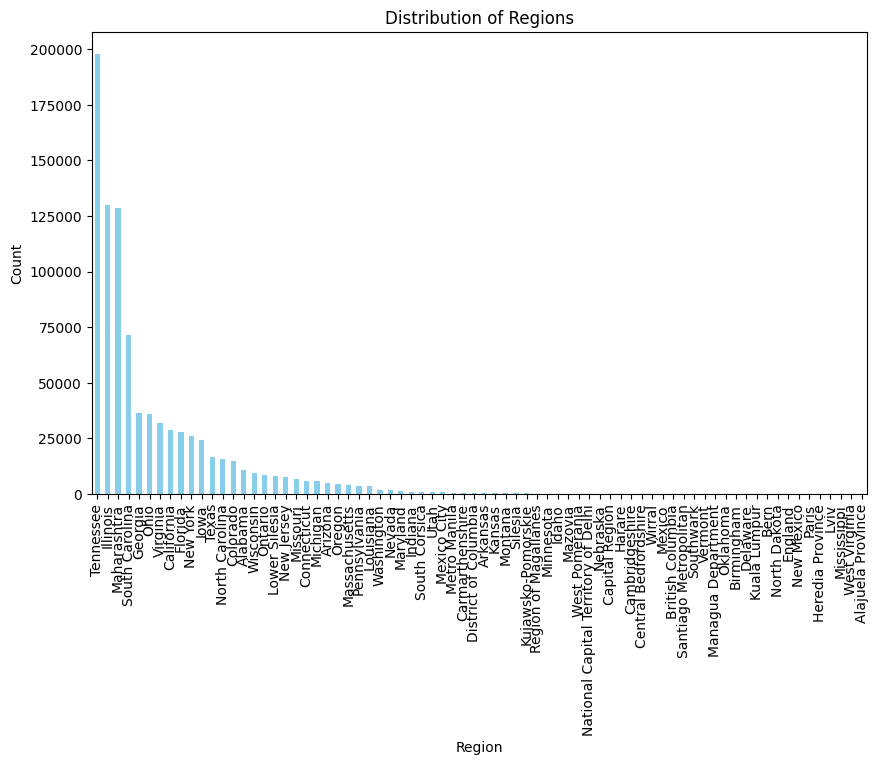


Number of missing values in 'region': 302


In [53]:
# Unique values in the 'region' column
print("Unique values in 'region':")

# Value counts for the 'region' column
region_counts = combined_df_2024['region'].value_counts()
print("\nValue counts for 'region':")
print(region_counts)

# Distribution of regions (bar plot)
plt.figure(figsize=(10, 6))
region_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Regions')
plt.xlabel('Region')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

# Missing values in the 'region' column
missing_values = combined_df_2024['region'].isnull().sum()
print(f"\nNumber of missing values in 'region': {missing_values}")

### Key Insights from the 'region' Column Analysis (2024):

1. **Most Frequent Regions**:  
   - The most common regions in the dataset are **Tennessee (197,819 occurrences), Illinois (129,884), and Maharashtra (128,569)**.  
   - These regions have significantly higher user activity compared to others, suggesting they may be key locations where the platform is heavily used.

2. **Diverse Regional Representation**:  
   - There are **74 unique regions** in the dataset.  
   - This indicates a broad geographic reach, though some regions have very low representation.

3. **Least Frequent Regions**:  
   - Some regions, such as **Alajuela Province (1), West Virginia (1), and Mississippi (2)**, have minimal activity.  
   - These could be areas with low adoption or rare user presence.

Specifically examining 2025combined_file.csv

Unique values in 'region':

Value counts for 'region':
region
Maharashtra            399477
Tennessee              383475
Illinois               103032
Iowa                    95680
Georgia                 75776
                        ...  
Hampshire                   8
Wisconsin                   7
Hesse                       1
Wyoming                     1
City of Westminster         1
Name: count, Length: 69, dtype: int64


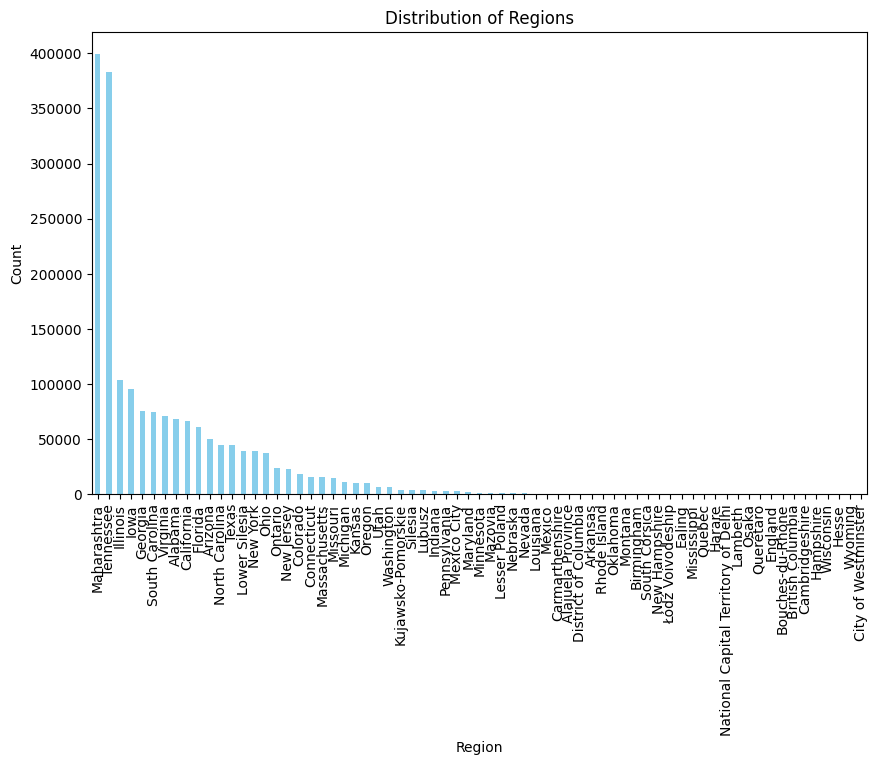


Number of missing values in 'region': 16521


In [54]:
# Unique values in the 'region' column
print("Unique values in 'region':")

# Value counts for the 'region' column
region_counts = combined_df_2025['region'].value_counts()
print("\nValue counts for 'region':")
print(region_counts)

# Distribution of regions (bar plot)
plt.figure(figsize=(10, 6))
region_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Regions')
plt.xlabel('Region')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

# Missing values in the 'region' column
missing_values = combined_df_2025['region'].isnull().sum()
print(f"\nNumber of missing values in 'region': {missing_values}")

### Key Insights from the 'region' Column (2025):

1. **Shift in Most Frequent Regions**:  
   - **Maharashtra (399,477)** has overtaken **Tennessee (383,475)** as the most common region.  
   - **Illinois (103,032)** remains significant, but its count has dropped compared to 2024.  
   - This suggests a **possible geographic shift in user activity**, with **Maharashtra growing rapidly**.

2. **New Regional Trends**:  
   - **Iowa (95,680)** and **Georgia (75,776)** are now among the top five, showing notable increases.  
   - **South Carolina**, which was ranked fourth in 2024, is no longer in the top five.  

3. **Slightly Reduced Diversity**:  
   - The number of **unique regions has decreased from 74 (2024) to 69 (2025)**.  
   - Some regions may have been merged, reclassified, or dropped due to inactivity.

4. **Least Frequent Regions**:  
   - **Hesse (1), Wyoming (1), and City of Westminster (1)** have minimal activity, similar to the previous year’s low-count regions.  

5. **Significant Increase in Missing Values**  
   - In **2024**, there were only **302** missing values, but in **2025**, this number **spiked to 16,521**.  
   - Potential causes include:  
     - **Data Collection Issues** – A change in how 'region' is recorded.  
     - **Expansion to New Markets** – Some regions may not be well-tracked yet.  
     - **User Behavior Changes** – Users may no longer provide location data as frequently.  

### Examining os_version Column

Specifically examining 2024combined_file.csv

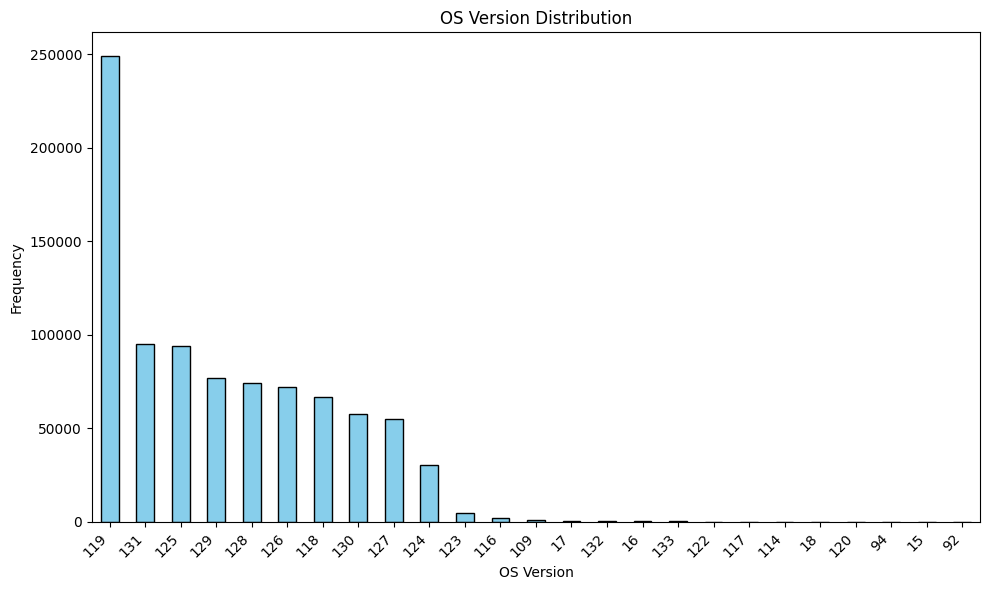

In [55]:
# Clean the 'os_version' column by extracting the first part of the version number
combined_df_2024['os_version'] = combined_df_2024['os_version'].apply(lambda x: str(x).split('.')[0] if isinstance(x, str) else str(x))

# Value counts for 'os_version'
value_counts = combined_df_2024['os_version'].value_counts()

# Plot the distribution of 'os_version' as a bar plot
plt.figure(figsize=(10, 6))
value_counts.plot(kind='bar', color='skyblue', edgecolor='black')

plt.title('OS Version Distribution')
plt.xlabel('OS Version')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()

Specifically examining 2025combined_file.csv

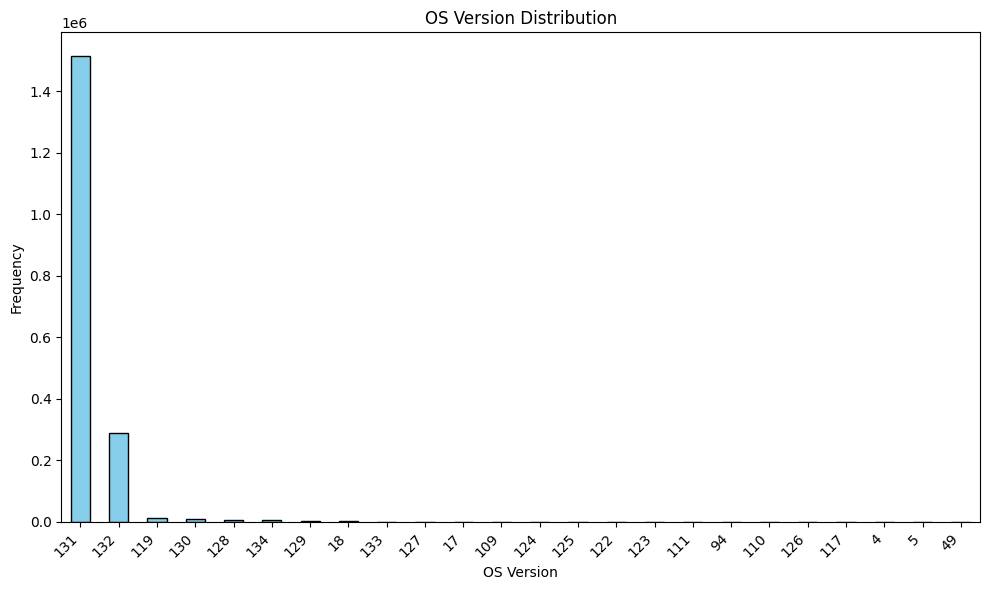

In [56]:
# Clean the 'os_version' column by extracting the first part of the version number
combined_df_2025['os_version'] = combined_df_2025['os_version'].apply(lambda x: str(x).split('.')[0] if isinstance(x, str) else str(x))

# Value counts for 'os_version'
value_counts = combined_df_2025['os_version'].value_counts()

# Plot the distribution of 'os_version' as a bar plot
plt.figure(figsize=(10, 6))
value_counts.plot(kind='bar', color='skyblue', edgecolor='black')

plt.title('OS Version Distribution')
plt.xlabel('OS Version')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()

### Examining platform Column

Specifically examining 2024combined_file.csv

In [57]:
# Missing values in 'platform' column
missing_values = combined_df_2024['platform'].isnull().sum()

# Unique values in 'platform'
unique_values = combined_df_2024['platform'].unique()

# Value counts for 'platform'
platform_counts = combined_df_2024['platform'].value_counts()

# Display the results
print(f"Missing values in 'platform': {missing_values}")
print(f"Unique values in 'platform': {unique_values}")
print("\nValue counts for 'platform':\n", platform_counts)

Missing values in 'platform': 0
Unique values in 'platform': ['Web']

Value counts for 'platform':
 platform
Web    883027
Name: count, dtype: int64


### Key Insights from the 'Platform' Column (2024):

1. **Unique Values**:
   - The column contains **only one unique value**: `Web`.

2. **Value Counts**:
   - The **'Web'** platform appears **883,027 times**, indicating that the dataset primarily consists of data from web-based platforms.


Specifically examining 2025combined_file.csv

In [58]:
# Missing values in 'platform' column
missing_values = combined_df_2025['platform'].isnull().sum()

# Unique values in 'platform'
unique_values = combined_df_2025['platform'].unique()

# Value counts for 'platform'
platform_counts = combined_df_2025['platform'].value_counts()

# Display the results
print(f"Missing values in 'platform': {missing_values}")
print(f"Unique values in 'platform': {unique_values}")
print("\nValue counts for 'platform':\n", platform_counts)

Missing values in 'platform': 0
Unique values in 'platform': ['Web']

Value counts for 'platform':
 platform
Web    1850109
Name: count, dtype: int64


### Key Insights from the 'Platform' Column (2025):

1. **Unique Values**:
   - The column contains **only one unique value**: `Web`.

2. **Value Counts**:
   - The **'Web'** platform appears **1,850,109 times**, showing that the dataset for 2025, like the 2024 dataset, consists solely of web-based platform data.

### Examining os_name Column

Specifically examining 2024combined_file.csv

Missing values in 'os_name': 0
Unique values in 'os_name': ['Chrome' 'Edge' 'Firefox' 'Mobile Safari' 'Safari' 'Chrome Mobile iOS'
 'Chrome Mobile' 'HeadlessChrome']

Value counts for 'os_name':
 os_name
Chrome               838274
Edge                  41424
Firefox                2167
Safari                  599
Mobile Safari           489
Chrome Mobile iOS        62
Chrome Mobile             7
HeadlessChrome            5
Name: count, dtype: int64


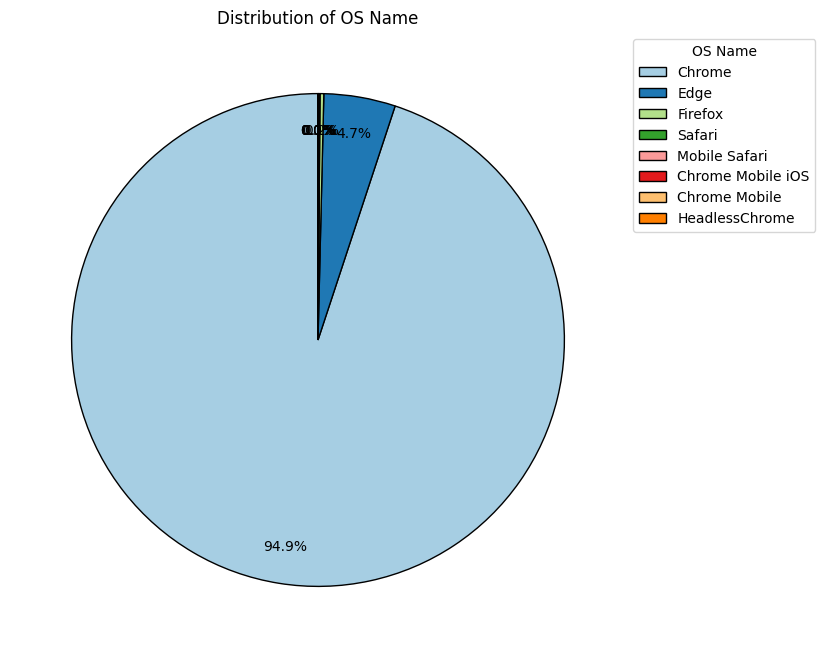

In [59]:
# Check for missing values in 'os_name' column
missing_values = combined_df_2024['os_name'].isnull().sum()

# Unique values in 'os_name'
unique_values = combined_df_2024['os_name'].unique()

# Value counts for 'os_name'
os_name_counts = combined_df_2024['os_name'].value_counts()

# Display the results
print(f"Missing values in 'os_name': {missing_values}")
print(f"Unique values in 'os_name': {unique_values}")
print("\nValue counts for 'os_name':\n", os_name_counts)

# Count the occurrences of each unique value in 'os_name'
os_name_counts = combined_df_2024['os_name'].value_counts()

plt.figure(figsize=(10, 8))

# Create the pie chart without the text labels
plt.pie(os_name_counts, 
        autopct='%1.1f%%', 
        startangle=90, 
        colors=plt.cm.Paired.colors,
        wedgeprops={'edgecolor': 'black'},
        pctdistance=0.85)

# Add a legend (key box) with the 'os_name' labels and their respective counts
plt.legend(os_name_counts.index, 
           title="OS Name", 
           loc="upper left", 
           bbox_to_anchor=(1, 1), 
           fontsize=10)

plt.title('Distribution of OS Name')
plt.show()

### Key Insights from the 'OS Name' Column (2024):

1. **Unique Values**:
   - The column contains **8 unique OS names**: `Chrome`, `Edge`, `Firefox`, `Mobile Safari`, `Safari`, `Chrome Mobile iOS`, `Chrome Mobile`, and `HeadlessChrome`.

2. **Value Counts**:
   - **Chrome** is the most common OS, appearing **838,274 times**.
   - Other notable OS names include **Edge** (41,424), **Firefox** (2,167), and **Safari** (599).
   - **Chrome Mobile** (7) and **HeadlessChrome** (5) have minimal occurrences.

3. **Visualization**:
   - A pie chart was created to visualize the distribution of OS names. Chrome dominates the dataset with a large percentage, followed by Edge and Firefox.

Specifically examining 2025combined_file.csv

Missing values in 'os_name': 0
Unique values in 'os_name': ['Chrome' 'Edge' 'Firefox' 'Mobile Safari' 'HeadlessChrome'
 'Chrome Mobile iOS' 'Edge Mobile' 'Safari' 'Chrome Mobile' 'android']

Value counts for 'os_name':
 os_name
Chrome               1707543
Edge                  131340
Firefox                 8543
Mobile Safari           1822
Safari                   637
Chrome Mobile iOS        163
Edge Mobile               36
Chrome Mobile             22
HeadlessChrome             2
android                    1
Name: count, dtype: int64


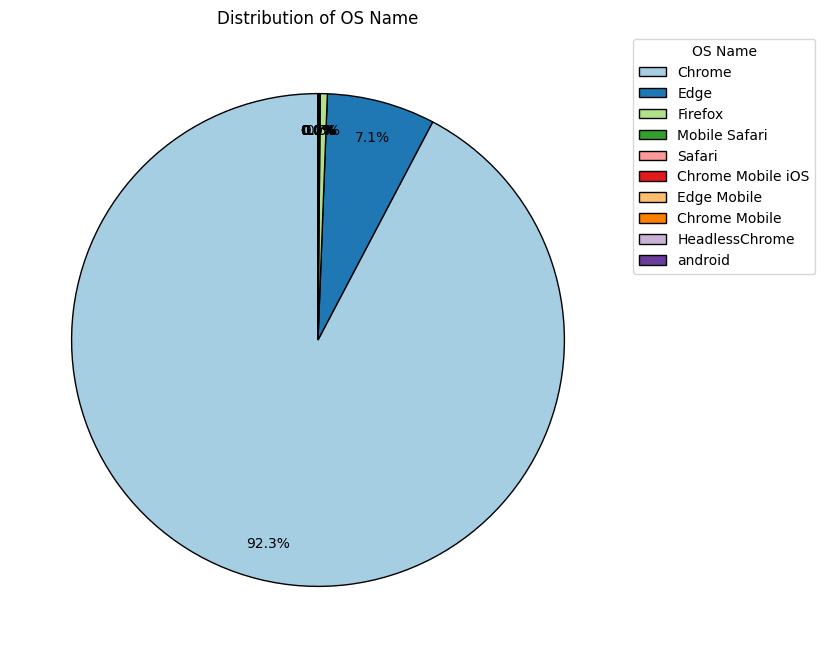

In [61]:
# Check for missing values in 'os_name' column
missing_values = combined_df_2025['os_name'].isnull().sum()

# Unique values in 'os_name'
unique_values = combined_df_2025['os_name'].unique()

# Value counts for 'os_name'
os_name_counts = combined_df_2025['os_name'].value_counts()

# Display the results
print(f"Missing values in 'os_name': {missing_values}")
print(f"Unique values in 'os_name': {unique_values}")
print("\nValue counts for 'os_name':\n", os_name_counts)

# Count the occurrences of each unique value in 'os_name'
os_name_counts = combined_df_2025['os_name'].value_counts()

plt.figure(figsize=(10, 8))

# Create the pie chart without the text labels
plt.pie(os_name_counts, 
        autopct='%1.1f%%', 
        startangle=90, 
        colors=plt.cm.Paired.colors,
        wedgeprops={'edgecolor': 'black'},
        pctdistance=0.85)

# Add a legend (key box) with the 'os_name' labels and their respective counts
plt.legend(os_name_counts.index, 
           title="OS Name", 
           loc="upper left", 
           bbox_to_anchor=(1, 1), 
           fontsize=10)

plt.title('Distribution of OS Name')
plt.show()

### Key Insights from the 'OS Name' Column (2025):

1. **Unique Values**:
   - The column contains **10 unique OS names**: `Chrome`, `Edge`, `Firefox`, `Mobile Safari`, `HeadlessChrome`, `Chrome Mobile iOS`, `Edge Mobile`, `Safari`, `Chrome Mobile`, and `android`.

2. **Value Counts**:
   - **Chrome** is by far the most frequent OS, appearing **1,707,543 times**.
   - Other notable OS names include **Edge** (131,340), **Firefox** (8,543), and **Mobile Safari** (1,822).
   - The dataset also includes minor entries like **android** (1) and **HeadlessChrome** (2), which appear very infrequently.

3. **Visualization**:
   - A pie chart was created to visualize the distribution of OS names. **Chrome** dominates the dataset, followed by **Edge** and **Firefox**, with the rest of the OS names making up a small fraction.

### Examining device_type Column

Specifically examining 2024combined_file.csv

Unique values in 'device_type': [nan 'Windows' 'Mac' 'Linux' 'Apple iPhone' 'Android' 'Chromium OS'
 'Google Nexus 5']

Frequency distribution:
 device_type
Windows           690115
Mac                72718
Linux              21753
Chromium OS          463
Apple iPhone         187
Google Nexus 5        81
Android                7
Name: count, dtype: int64

Missing values: 97703

Summary Statistics:
 count      785324
unique          7
top       Windows
freq       690115
Name: device_type, dtype: object


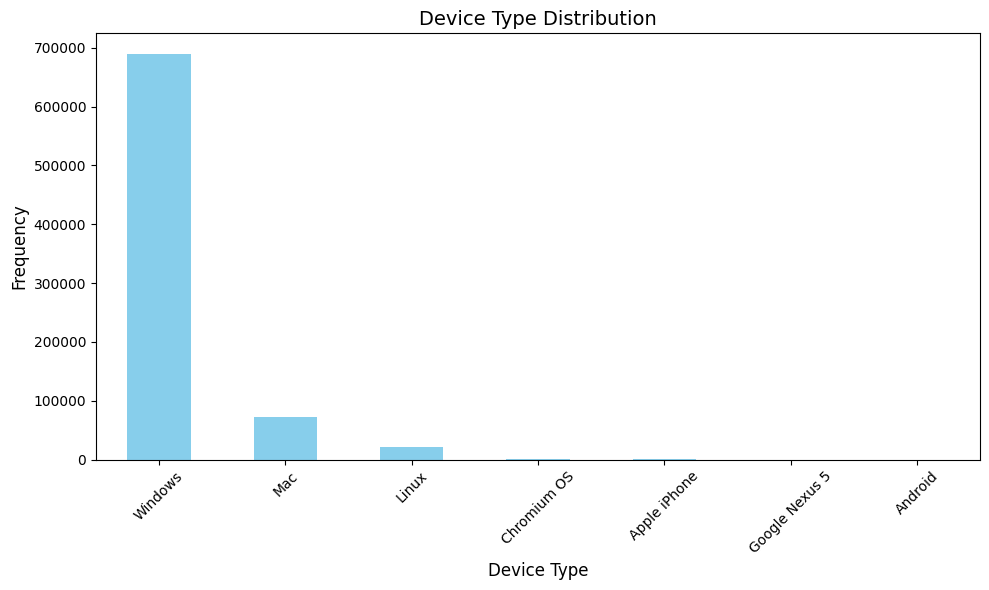

In [62]:
# Unique Values
unique_device_types = combined_df_2024['device_type'].unique()
print("Unique values in 'device_type':", unique_device_types)

# Frequency Distribution
device_type_freq = combined_df_2024['device_type'].value_counts()
print("\nFrequency distribution:\n", device_type_freq)

# Missing Values
missing_device_types = combined_df_2024['device_type'].isnull().sum()
print("\nMissing values:", missing_device_types)

# Summary Statistics
device_type_summary = combined_df_2024['device_type'].describe()
print("\nSummary Statistics:\n", device_type_summary)


# Plot the frequency distribution
plt.figure(figsize=(10, 6))
device_type_freq = combined_df_2024['device_type'].value_counts()
device_type_freq.plot(kind='bar', color='skyblue')

# Add title and labels
plt.title('Device Type Distribution', fontsize=14)
plt.xlabel('Device Type', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Show the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Key Insights from the 'Device Type' Column (2024):

1. **Unique Values**:
   - There are **7 unique device types**: `Windows`, `Mac`, `Linux`, `Apple iPhone`, `Android`, `Chromium OS`, and `Google Nexus 5`.
   - There are also **missing values** (`nan`).

2. **Frequency Distribution**:
   - **Windows** is the dominant device type, with **690,115 occurrences**.
   - Other notable types include **Mac** (72,718), **Linux** (21,753), and **Chromium OS** (463).
   - **Android** appears only **7 times**, and **Google Nexus 5** has **81 occurrences**.

3. **Missing Values**:
   - There are **97,703 missing values** in the `device_type` column, which is significant (around 12% of the total entries).

4. **Summary Statistics**:
   - The column contains **785,324 total entries**, with **7 unique device types**.
   - **Windows** is the most frequent device type, appearing **690,115 times**.

Specifically examining 2025combined_file.csv

Unique values in 'device_type': ['Windows' nan 'Linux' 'Android']

Frequency distribution:
 device_type
Windows    1513654
Linux        46239
Android         23
Name: count, dtype: int64

Missing values: 290193

Summary Statistics:
 count     1559916
unique          3
top       Windows
freq      1513654
Name: device_type, dtype: object


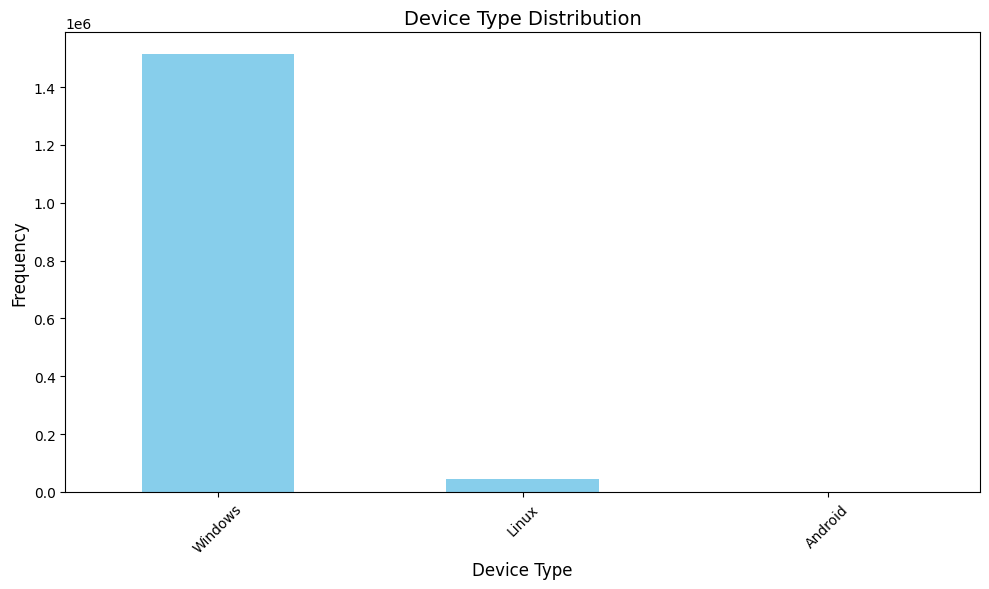

In [63]:
# Unique Values
unique_device_types = combined_df_2025['device_type'].unique()
print("Unique values in 'device_type':", unique_device_types)

# Frequency Distribution
device_type_freq = combined_df_2025['device_type'].value_counts()
print("\nFrequency distribution:\n", device_type_freq)

# Missing Values
missing_device_types = combined_df_2025['device_type'].isnull().sum()
print("\nMissing values:", missing_device_types)

# Summary Statistics
device_type_summary = combined_df_2025['device_type'].describe()
print("\nSummary Statistics:\n", device_type_summary)


# Plot the frequency distribution
plt.figure(figsize=(10, 6))
device_type_freq = combined_df_2025['device_type'].value_counts()
device_type_freq.plot(kind='bar', color='skyblue')

# Add title and labels
plt.title('Device Type Distribution', fontsize=14)
plt.xlabel('Device Type', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Show the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Key Insights from the 'Device Type' Column (2025):

1. **Unique Values**:
   - The column contains **three unique device types**: `Windows`, `Linux`, and `Android`.

2. **Frequency Distribution**:
   - **Windows** is the most prevalent device type, with **1,513,654 occurrences**.
   - **Linux** comes second, with **46,239 occurrences**.
   - **Android** appears **23 times**, a much lower frequency.

3. **Missing Values**:
   - There are **290,193 missing values** in the `device_type` column, which is a significant portion of the dataset.

4. **Summary Statistics**:
   - The column has **1,559,916 total entries**, with **three unique device types**.
   - The most common device type is **Windows**, appearing **1,513,654 times**.

### Examining device_family Column

Specifically examining 2024combined_file.csv

Missing values in 'device_family': 0
Device Family Distribution:
device_family
Windows               690115
Mac OS X               97082
Mac                    72718
Linux                  21753
Chromium OS              463
iOS                      432
K                        189
Apple iPhone             187
Google Nexus Phone        81
Android                    7
Name: count, dtype: int64


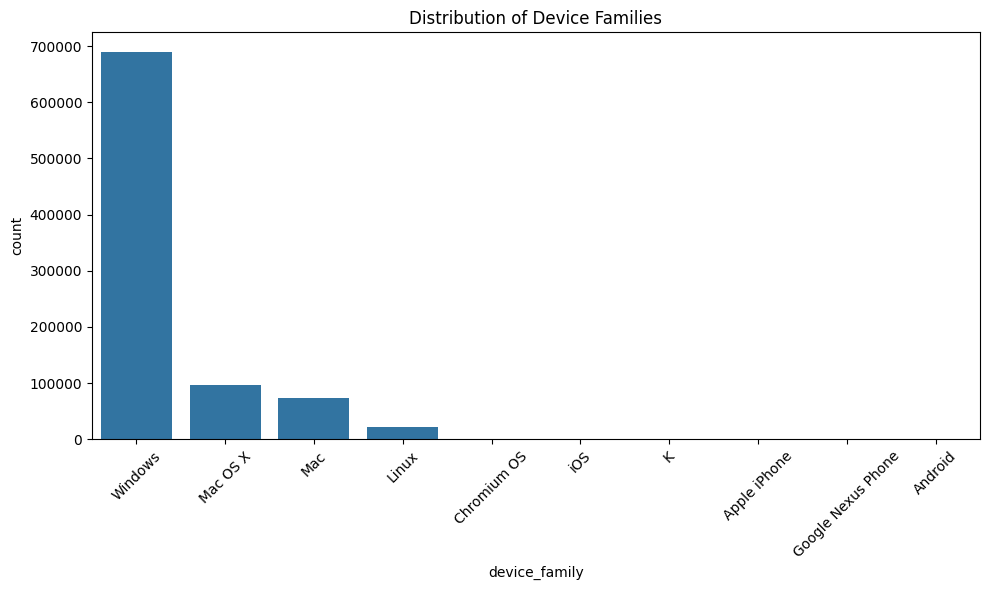

Device Families:
device_family
Windows               690115
Mac OS X               97082
Mac                    72718
Linux                  21753
Chromium OS              463
iOS                      432
K                        189
Apple iPhone             187
Google Nexus Phone        81
Android                    7
Name: count, dtype: int64


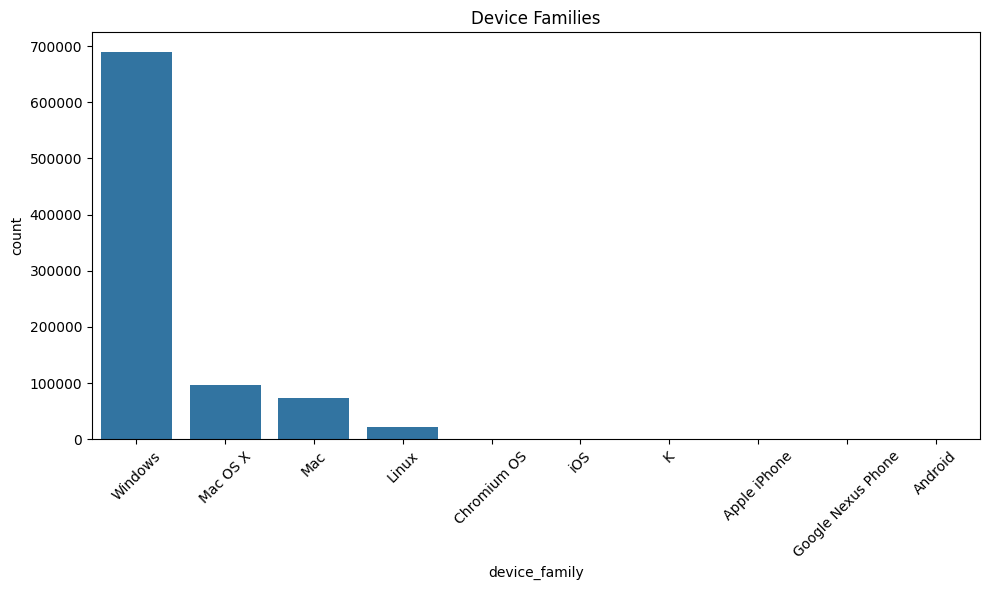

In [ ]:
# Check for missing values in the 'device_family' column
missing_values = combined_df_2024['device_family'].isnull().sum()
print(f"Missing values in 'device_family': {missing_values}")

# Distribution of the 'device_family' column
device_family_counts = combined_df_2024['device_family'].value_counts()
print(f"Device Family Distribution:\n{device_family_counts}")

# Plot the distribution of device families
plt.figure(figsize=(10,6))
sns.countplot(data=combined_df_2024, x='device_family', order=device_family_counts.index)
plt.title('Distribution of Device Families')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Key Insights from the 'Device Family' Column (2024):

1. **Device Family Distribution**:
   - The **Windows** platform is the most frequent, with **690,115 entries**, followed by **Mac OS X** (**97,082 entries**).
   - Other prominent device families include **Mac** (**72,718 entries**) and **Linux** (**21,753 entries**).
   - Less common device families include **Chromium OS** (**463 entries**), **iOS** (**432 entries**), and **Android** (**7 entries**).

2. **Device Family Visualization**:
   - The distribution is heavily dominated by **Windows** and **Mac OS X**, with many other device families having much lower counts.
   - Smaller groups include various mobile devices like **Apple iPhone**, **Google Nexus Phone**, and **Android**.

Specifically examining 2025combined_file.csv

Missing values in 'device_family': 0
Device Family Distribution:
device_family
Windows     1513654
Mac OS X     288172
Linux         46239
iOS            2021
Android          23
Name: count, dtype: int64


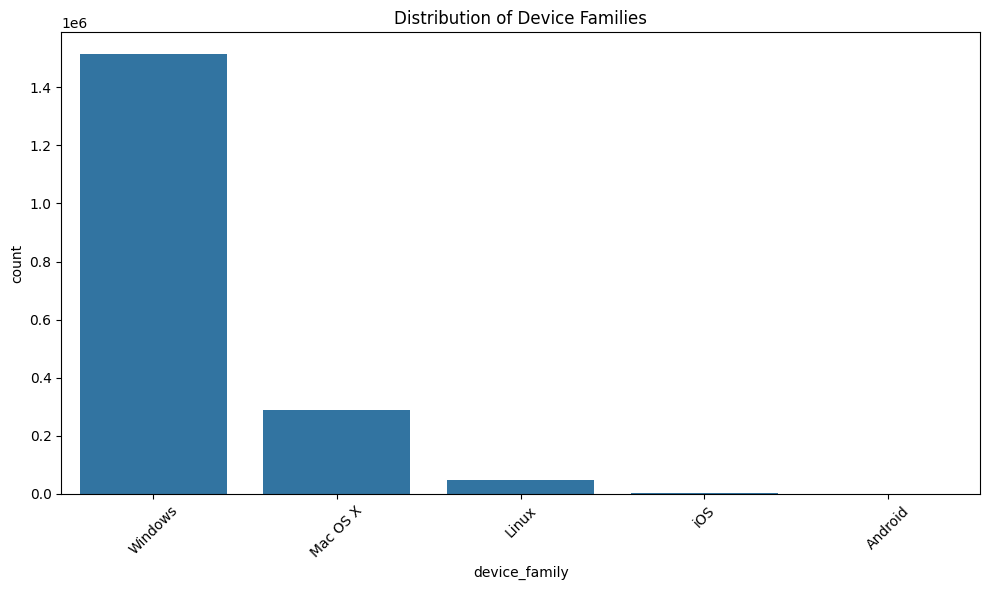

Device Families:
device_family
Windows     1513654
Mac OS X     288172
Linux         46239
iOS            2021
Android          23
Name: count, dtype: int64


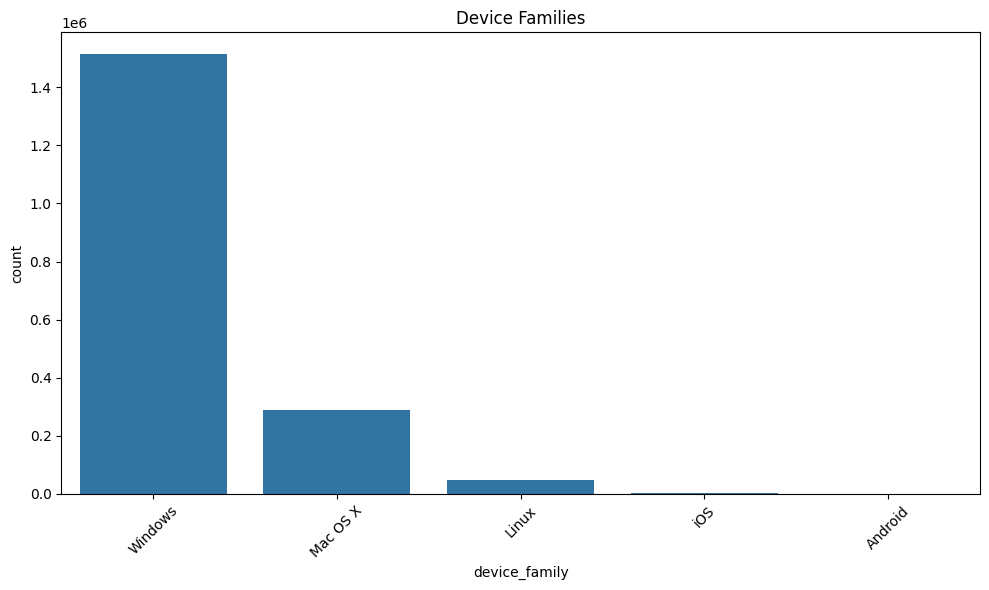

In [ ]:
# Check for missing values in the 'device_family' column
missing_values = combined_df_2025['device_family'].isnull().sum()
print(f"Missing values in 'device_family': {missing_values}")

# Distribution of the 'device_family' column
device_family_counts = combined_df_2025['device_family'].value_counts()
print(f"Device Family Distribution:\n{device_family_counts}")

# Plot the distribution of device families
plt.figure(figsize=(10,6))
sns.countplot(data=combined_df_2025, x='device_family', order=device_family_counts.index)
plt.title('Distribution of Device Families')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Key Insights from the 'Device Family' Column (2025):

1. **Device Family Distribution**:
   - The **Windows** platform leads the dataset with **1,513,654 entries**, followed by **Mac OS X** (**288,172 entries**).
   - **Linux** contributes **46,239 entries**, while **iOS** has **2,021 entries**, and **Android** has **23 entries**.

2. **Device Family Visualization**:
   - The distribution is highly skewed, with **Windows** and **Mac OS X** representing the majority of device families.
   - Other operating systems (Linux, iOS, and Android) have significantly smaller counts.

### Examining country Column

Specifically examining 2024combined_file.csv

country
United States     733287
India             128660
Poland              8870
Canada              8655
France               802
United Kingdom       754
Mexico               726
Philippines          659
Chile                232
Puerto Rico          169
Denmark               77
Zimbabwe              74
Nicaragua             21
Malaysia              16
Switzerland           15
Costa Rica             6
Ukraine                4
Name: count, dtype: int64
Missing values in 'country' column: 0


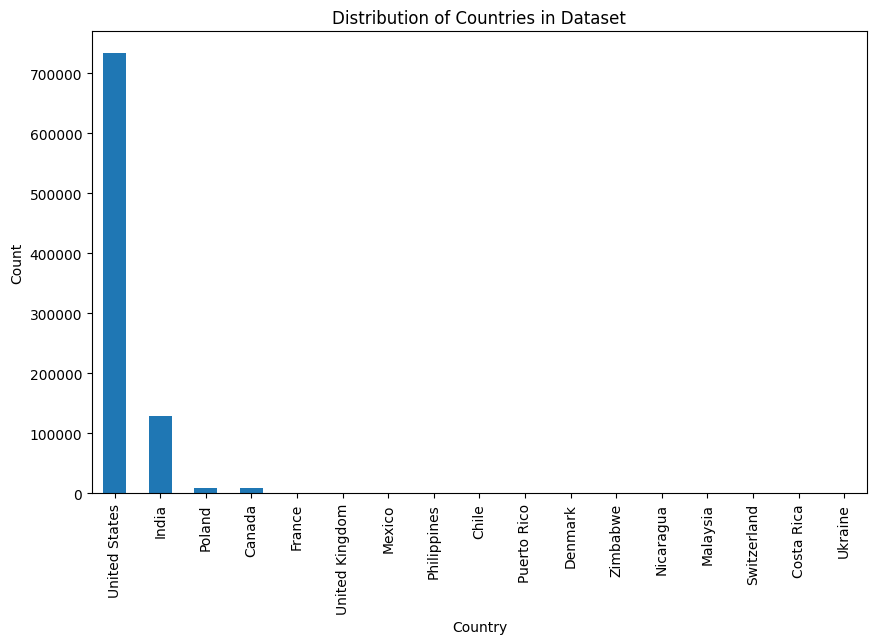

Unique countries in the dataset: ['United States' 'India' 'Canada' 'Mexico' 'Poland' 'France'
 'United Kingdom' 'Puerto Rico' 'Philippines' 'Denmark' 'Switzerland'
 'Costa Rica' 'Zimbabwe' 'Nicaragua' 'Chile' 'Malaysia' 'Ukraine']
Number of unique countries: 17


In [66]:
country_counts = combined_df_2024['country'].value_counts()
print(country_counts)

# Check for missing values
missing_values = combined_df_2024['country'].isnull().sum()
print(f"Missing values in 'country' column: {missing_values}")

# Visualize the distribution of countries
plt.figure(figsize=(10, 6))
country_counts.plot(kind='bar')
plt.xticks(rotation=90)
plt.title('Distribution of Countries in Dataset')
plt.xlabel('Country')
plt.ylabel('Count')
plt.show()

# Check for unique country names
unique_countries = combined_df_2024['country'].unique()
print(f"Unique countries in the dataset: {unique_countries}")

unique_countries = combined_df_2024['country'].nunique()
print("Number of unique countries:", unique_countries)

### Key Insights from the 'Country' Column (2024):

1. **Top Countries**:
   - The majority of the data comes from the **United States** (**733,287 entries**), followed by **India** (**128,660 entries**), **Poland** (**8,870 entries**), and **Canada** (**8,655 entries**).
   - Other countries like **Mexico**, **United Kingdom**, and **Philippines** contribute relatively smaller portions to the dataset.

2. **Unique Countries**:
   - There are **17 unique countries** in the dataset, which include a mix of North American, European, and Asian countries, with **United States** and **India** being the most dominant contributors.

3. **Country Distribution**:
   - The dataset heavily leans toward **United States** and **India**, while other countries represent niche portions, with **Ukraine**, **Malaysia**, and **Costa Rica** having minimal contributions.

Specifically examining 2025combined_file.csv

country
United States     1370823
India              399503
Poland              52844
Canada              23210
Mexico               2782
United Kingdom        526
Costa Rica            167
Singapore             101
France                 78
Puerto Rico            27
Zimbabwe               26
Japan                  20
Germany                 2
Name: count, dtype: int64
Missing values in 'country' column: 0


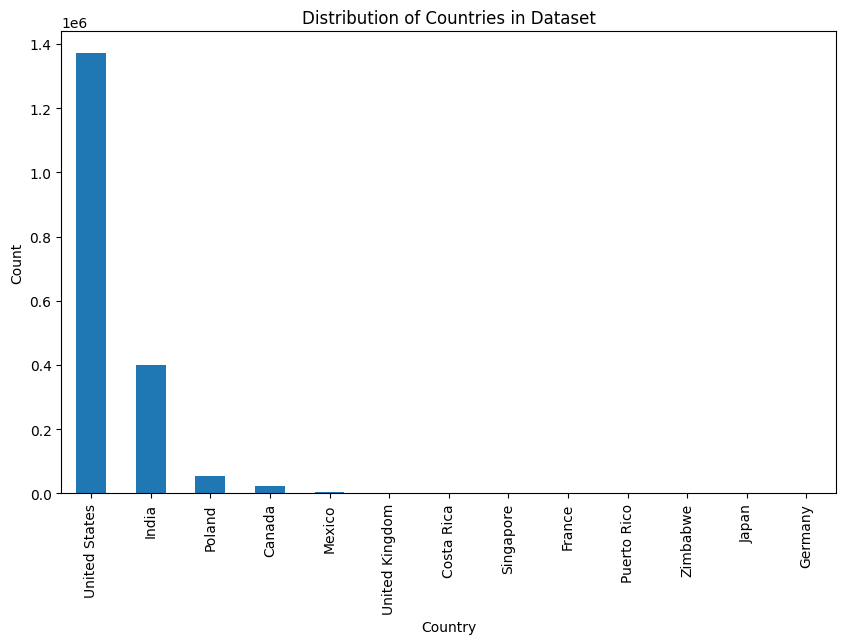

Unique countries in the dataset: ['India' 'United States' 'Poland' 'Canada' 'Mexico' 'Singapore'
 'United Kingdom' 'Germany' 'Costa Rica' 'Japan' 'Puerto Rico' 'Zimbabwe'
 'France']
Number of unique countries: 13


In [67]:
country_counts = combined_df_2025['country'].value_counts()
print(country_counts)

# Check for missing values
missing_values = combined_df_2025['country'].isnull().sum()
print(f"Missing values in 'country' column: {missing_values}")

# Visualize the distribution of countries
plt.figure(figsize=(10, 6))
country_counts.plot(kind='bar')
plt.xticks(rotation=90)
plt.title('Distribution of Countries in Dataset')
plt.xlabel('Country')
plt.ylabel('Count')
plt.show()

# Check for unique country names
unique_countries = combined_df_2025['country'].unique()
print(f"Unique countries in the dataset: {unique_countries}")

unique_countries = combined_df_2025['country'].nunique()
print("Number of unique countries:", unique_countries)

### Key Insights from the 'Country' Column (2025):

1. **Top Countries**:
   - The **United States** dominates the dataset with **1,370,823 entries**, followed by **India** (**399,503 entries**).
   - **Poland** comes next with **52,844 entries**, and **Canada** has **23,210 entries**.
   - Other countries like **Mexico** (**2,782 entries**) and **United Kingdom** (**526 entries**) represent much smaller portions.

2. **Unique Countries**:
   - The dataset contains **13 unique countries**, with the top contributors being **United States**, **India**, and **Poland**.

3. **Country Distribution**:
   - The dataset is again heavily skewed toward the **United States** and **India**, with **Poland** also contributing a significant portion. 
   - Several countries have only a few entries, including **Germany** (**2 entries**), **France** (**78 entries**), and **Japan** (**20 entries**).

### Examining city Column

Specifically examining 2024combined_file.csv

Missing values in city column: 5295
Number of unique cities: 526
Top 10 most frequent cities:
city
Nashville     129409
Mumbai        128569
Chicago       122975
Greenville     39955
Franklin       33451
Arrington      22287
New York       22206
Columbus       13089
Atlanta        11724
Alexandria     11601
Name: count, dtype: int64


/var/folders/rw/2_yr05hd56b1rkq4976bf6w00000gn/T/ipykernel_36549/412757910.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_cities.index, y=top_cities.values, palette='viridis')


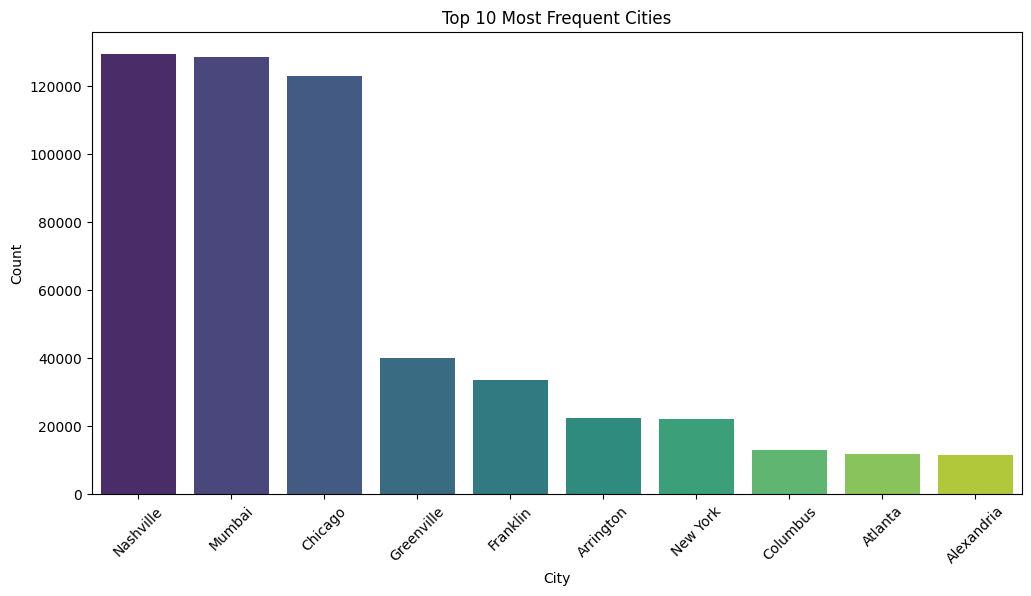

In [68]:
# Check for missing values in the 'city' column
missing_values = combined_df_2024['city'].isnull().sum()
print(f'Missing values in city column: {missing_values}')

# Drop rows with missing 'city' values
df_cleaned = combined_df_2024.dropna(subset=['city'])

# Get the count of unique cities
unique_cities_count = df_cleaned['city'].nunique()
print(f'Number of unique cities: {unique_cities_count}')

# Get the top 10 most frequent cities
top_cities = df_cleaned['city'].value_counts().head(10)
print(f'Top 10 most frequent cities:\n{top_cities}')

# Plot the top 10 most frequent cities
plt.figure(figsize=(12, 6))
sns.barplot(x=top_cities.index, y=top_cities.values, palette='viridis')
plt.title('Top 10 Most Frequent Cities')
plt.xlabel('City')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

### Key Insights from the 'City' Column (2024):

1. **Unique Cities**:
   - The dataset contains **526 unique cities**, indicating diverse geographic representation.

2. **Top 10 Cities**:
   - The top 10 most frequent cities are dominated by **Nashville (129,409)**, **Mumbai (128,569)**, and **Chicago (122,975)**, with a noticeable presence in both US and international cities.
   - Other notable cities include **Greenville**, **Franklin**, and **Arrington**, showing a concentration of activity in specific locations.

3. **City Distribution**:
   - The distribution highlights a few major cities that contribute significantly to the data, while the remaining cities have lower counts.

Specifically examining 2025combined_file.csv

Missing values in city column: 33543
Number of unique cities: 467
Top 10 most frequent cities:
city
Mumbai         399477
Nashville      286693
Spring Hill     74781
Chicago         71692
Birmingham      49854
Greenville      45706
Alexandria      38848
Wroclaw         33788
Phoenix         31894
Des Moines      27699
Name: count, dtype: int64


/var/folders/rw/2_yr05hd56b1rkq4976bf6w00000gn/T/ipykernel_36549/530745850.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_cities.index, y=top_cities.values, palette='viridis')


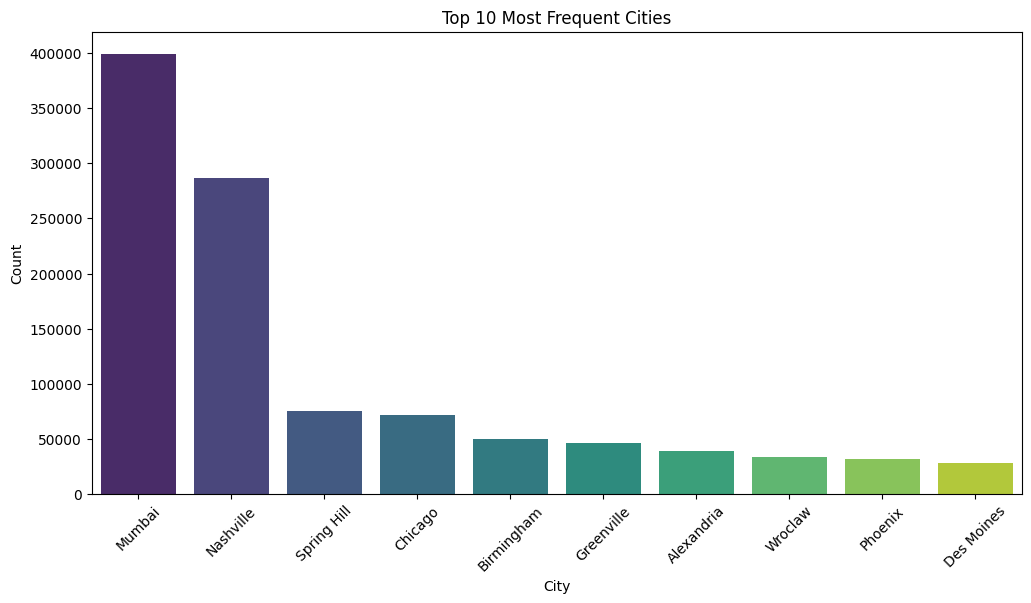

In [69]:
# Check for missing values in the 'city' column
missing_values = combined_df_2025['city'].isnull().sum()
print(f'Missing values in city column: {missing_values}')

# Drop rows with missing 'city' values
df_cleaned = combined_df_2025.dropna(subset=['city'])

# Get the count of unique cities
unique_cities_count = df_cleaned['city'].nunique()
print(f'Number of unique cities: {unique_cities_count}')

# Get the top 10 most frequent cities
top_cities = df_cleaned['city'].value_counts().head(10)
print(f'Top 10 most frequent cities:\n{top_cities}')

# Plot the top 10 most frequent cities
plt.figure(figsize=(12, 6))
sns.barplot(x=top_cities.index, y=top_cities.values, palette='viridis')
plt.title('Top 10 Most Frequent Cities')
plt.xlabel('City')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

### Key Insights from the 'City' Column (2025):

1. **Unique Cities**:
   - The dataset includes **467 unique cities**, reflecting a wide geographic distribution.

2. **Top 10 Cities**:
   - **Mumbai (399,477)** and **Nashville (286,693)** dominate the dataset, similar to the 2024 data, indicating consistent engagement in these cities.
   - Other top cities include **Spring Hill**, **Chicago**, and **Birmingham**, showcasing a blend of US and international locations like **Wroclaw**.

3. **City Distribution**:
   - A few cities, notably Mumbai and Nashville, have significantly more data entries compared to others, with the rest showing much lower counts.

### Examining language Column
Specifically examining 2024combined_file.csv

Missing values in language column: 0
Number of unique languages: 3
Top 10 most frequent languages:
language
English    877865
Polish       4450
Spanish       712
Name: count, dtype: int64


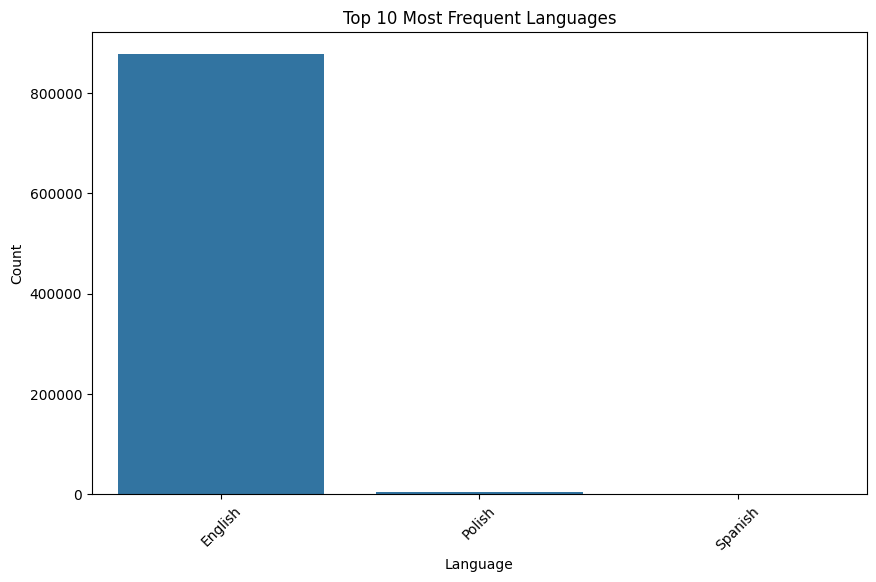

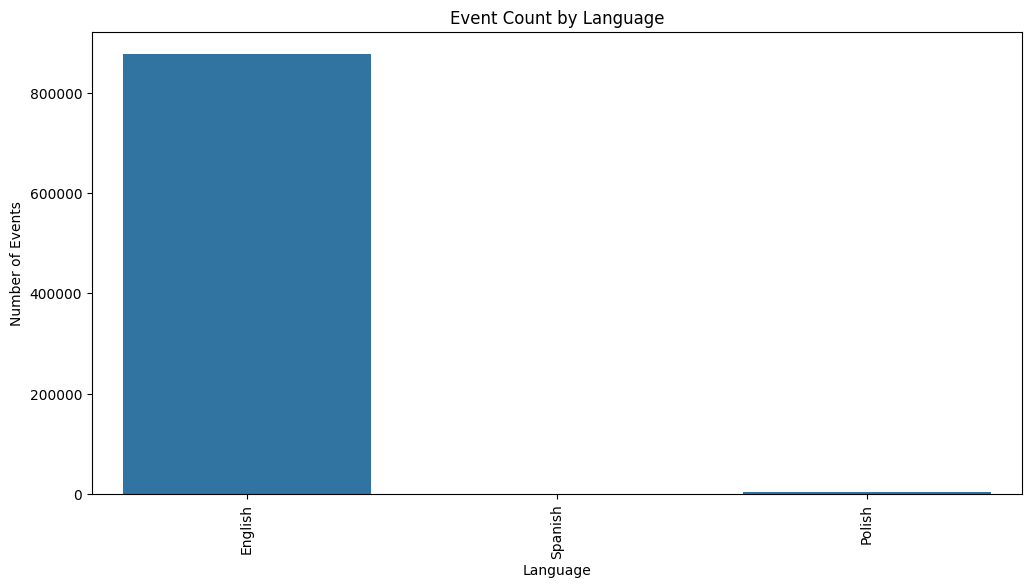

In [ ]:
# Check for missing values
print(f'Missing values in language column: {combined_df_2024["language"].isnull().sum()}')

# Clean the data (remove rows with missing language values)
df_cleaned = combined_df_2024.dropna(subset=['language'])

# Unique languages count and most frequent languages
print(f'Number of unique languages: {df_cleaned["language"].nunique()}')
top_languages = df_cleaned['language'].value_counts().head(10)
plt.show()

# Distribution of events by language
plt.figure(figsize=(12, 6))
sns.countplot(x='language', data=df_cleaned)
plt.title('Event Count by Language')
plt.xlabel('Language')
plt.ylabel('Number of Events')
plt.xticks(rotation=90)
plt.show()

### Key Insights from the Language Column (2024):

1. **Unique Languages**:
   - The dataset contains **3 unique languages**, indicating a limited linguistic range.

2. **Top Languages**:
   - **English** is the dominant language with **877,865 events**, representing the vast majority of the data.
   - **Polish** has a smaller presence with **4,450 events**, followed by **Spanish** with **712 events**, showing a significant drop in usage after English.

3. **Event Distribution**:
   - The majority of events are in **English**, while **Polish** and **Spanish** make up only a small fraction of the total events.

Specifically examining 2025combined_file.csv

Missing values in language column: 0
Number of unique languages: 3
Top 10 most frequent languages:
language
English    1826082
Polish       22051
Spanish       1976
Name: count, dtype: int64


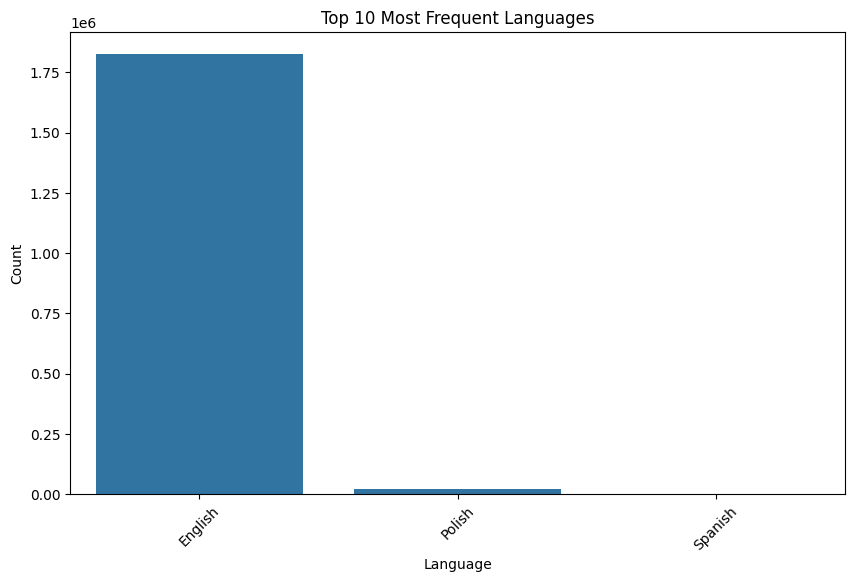

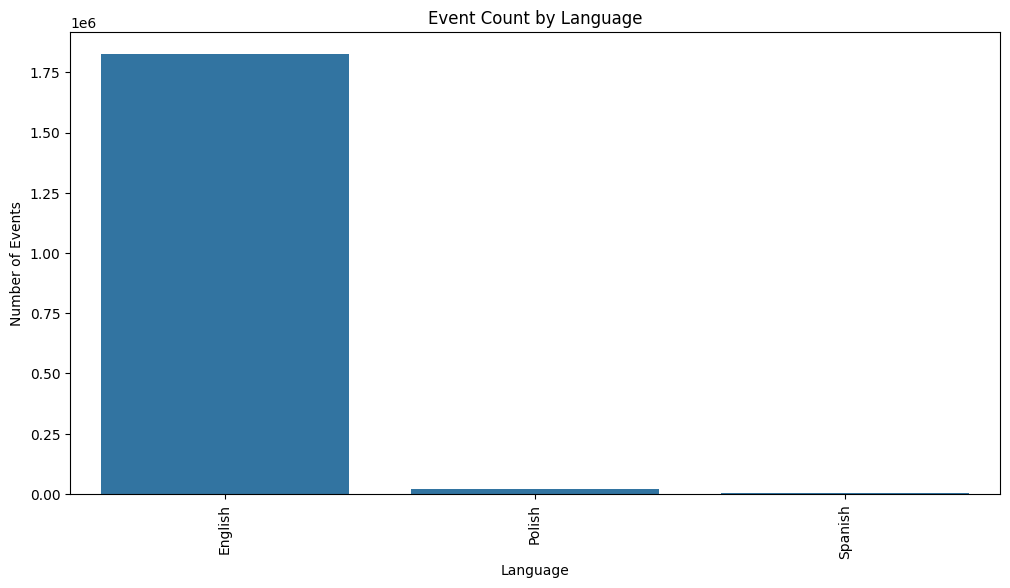

In [ ]:
# Check for missing values
print(f'Missing values in language column: {combined_df_2025["language"].isnull().sum()}')

# Clean the data (remove rows with missing language values)
df_cleaned = combined_df_2025.dropna(subset=['language'])

# Unique languages count and most frequent languages
print(f'Number of unique languages: {df_cleaned["language"].nunique()}')
top_languages = df_cleaned['language'].value_counts().head(10)

# Distribution of events by language
plt.figure(figsize=(12, 6))
sns.countplot(x='language', data=df_cleaned)
plt.title('Event Count by Language')
plt.xlabel('Language')
plt.ylabel('Number of Events')
plt.xticks(rotation=90)
plt.show()

### Key Insights from the Language Column (2025):

1. **Unique Languages**:
   - The dataset contains **3 unique languages**, showing a relatively low linguistic diversity.

2. **Top Languages**:
   - **English** dominates the dataset with **1,826,082 events**, accounting for the overwhelming majority.
   - **Polish** is the second most frequent language with **22,051 events**, followed by **Spanish** with **1,976 events**. These two languages reflect a smaller but notable portion of the user base.

3. **Event Distribution**:
   - **English** significantly outpaces the other languages in event count, while **Polish** and **Spanish** have much lower event volumes.

### Examining dma Column

Specifically examining 2024combined_file.csv

Missing values in dma column: 155155
Number of unique DMAs: 104
Top 10 most frequent DMAs:
dma
Nashville, TN                         189474
Chicago, IL                           129005
Greenville-Spartanburg, SC             68829
New York, NY                           35611
Atlanta, GA                            35441
Washington, DC (Hagerstown, MD)        24943
Des Moines-Ames, IA                    23411
Cleveland-Akron (Canton), OH           22348
San Francisco-Oakland-San Jose, CA     15658
Denver, CO                             14761
Name: count, dtype: int64


/var/folders/rw/2_yr05hd56b1rkq4976bf6w00000gn/T/ipykernel_36549/1867422611.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_dma.index, y=top_dma.values, palette='viridis')


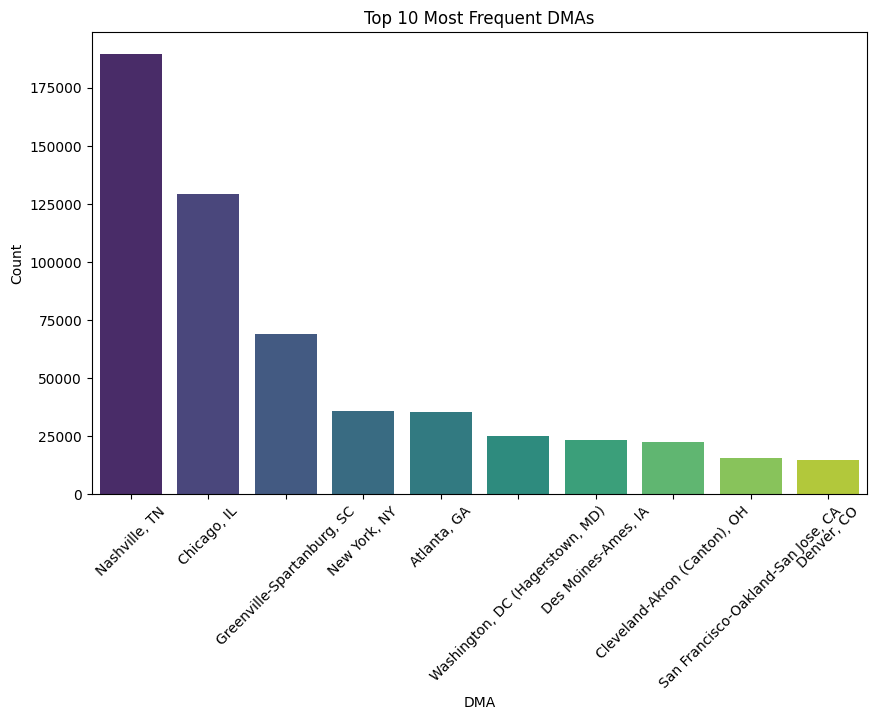

/var/folders/rw/2_yr05hd56b1rkq4976bf6w00000gn/T/ipykernel_36549/1867422611.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='dma', data=df_cleaned, palette='magma')


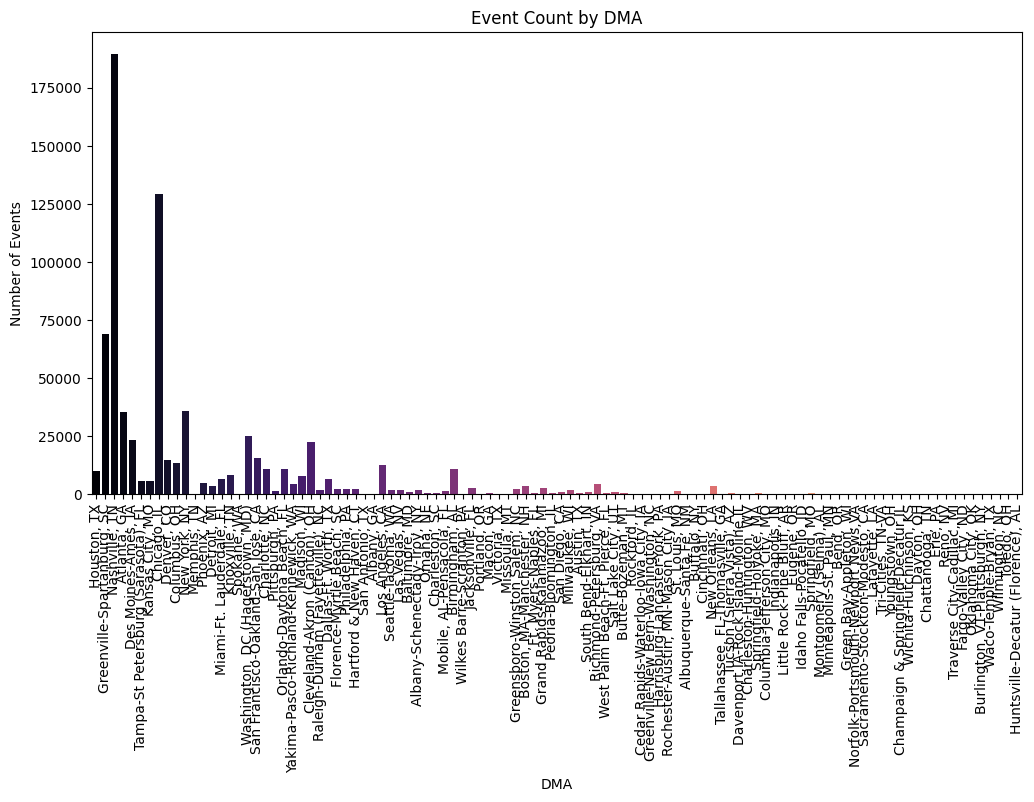

In [72]:
# Check for missing values in the dma column
print(f'Missing values in dma column: {combined_df_2024["dma"].isnull().sum()}')

# Clean the data (remove rows with missing dma values)
df_cleaned = combined_df_2024.dropna(subset=['dma'])

# Unique DMA count and most frequent DMAs
print(f'Number of unique DMAs: {df_cleaned["dma"].nunique()}')
top_dma = df_cleaned['dma'].value_counts().head(10)
print(f'Top 10 most frequent DMAs:\n{top_dma}')

# Plot top 10 most frequent DMAs
plt.figure(figsize=(10, 6))
sns.barplot(x=top_dma.index, y=top_dma.values, palette='viridis')
plt.title('Top 10 Most Frequent DMAs')
plt.xlabel('DMA')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# 5. Distribution of events by DMA
plt.figure(figsize=(12, 6))
sns.countplot(x='dma', data=df_cleaned, palette='magma')
plt.title('Event Count by DMA')
plt.xlabel('DMA')
plt.ylabel('Number of Events')
plt.xticks(rotation=90)
plt.show()

### **Key Insights from the DMA Column (2024)**  

1. **High Number of Missing Values**  
   - **155,155 missing values** were found in the **DMA** column.  
   - This accounts for a **significant portion of the dataset**, highlighting potential **data collection gaps**.  

2. **104 Unique DMAs Identified**  
   - After cleaning the data, **104 distinct DMAs** remain.  
   - This suggests **broad geographic representation**, but some **regions might be overrepresented** due to user concentration.  

3. **Most Frequent DMAs**  
   - The **top 10 DMAs** account for a large share of events.  
   - **Nashville, TN (189,474)** leads by a significant margin, followed by **Chicago, IL (129,005)** and **Greenville-Spartanburg, SC (68,829)**.  
   - Major cities like **New York (35,611), Atlanta (35,441), and Washington, DC (24,943)** also rank high.  

4. **Regional Concentration in the U.S.**  
   - The **top 10 DMAs** are all within the **United States**, indicating a **strong U.S. user base**.  
   - **Midwestern and Southern cities** (Nashville, Chicago, Greenville-Spartanburg, Des Moines) dominate, suggesting **regional platform adoption patterns**.  

Specifically examining 2025combined_file.csv

Missing values in dma column: 512300
Number of unique DMAs: 97
Top 10 most frequent DMAs:
dma
Nashville, TN                         366592
Chicago, IL                            94724
Des Moines-Ames, IA                    83549
Greenville-Spartanburg, SC             69668
Atlanta, GA                            67746
Birmingham, AL                         67256
New York, NY                           63715
Washington, DC (Hagerstown, MD)        62809
Phoenix, AZ                            49749
San Francisco-Oakland-San Jose, CA     31538
Name: count, dtype: int64


/var/folders/rw/2_yr05hd56b1rkq4976bf6w00000gn/T/ipykernel_36549/181381223.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_dma.index, y=top_dma.values, palette='viridis')


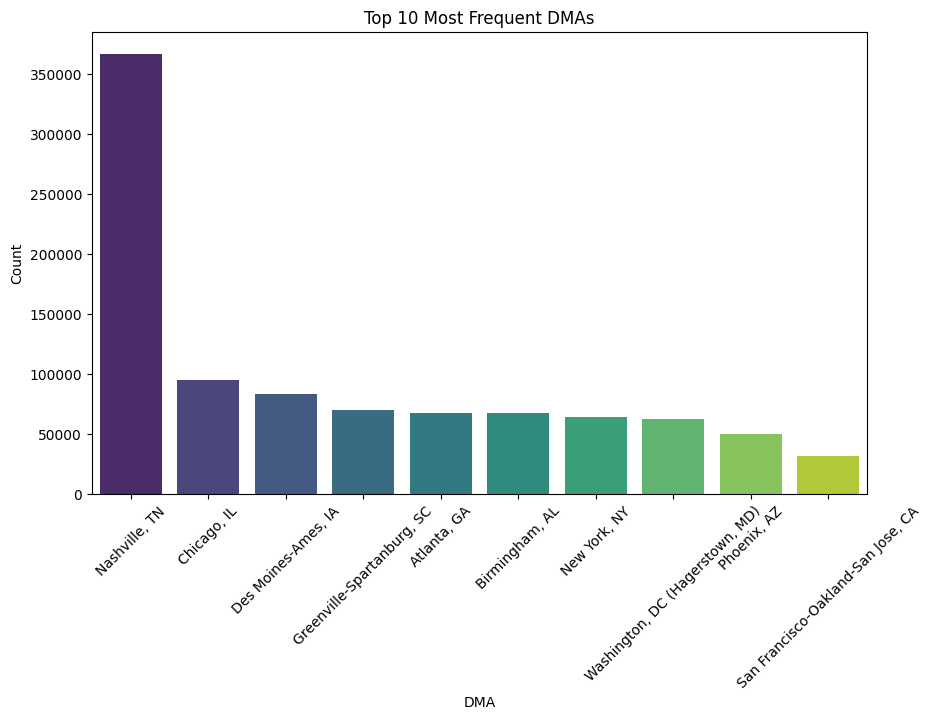

/var/folders/rw/2_yr05hd56b1rkq4976bf6w00000gn/T/ipykernel_36549/181381223.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='dma', data=df_cleaned, palette='magma')


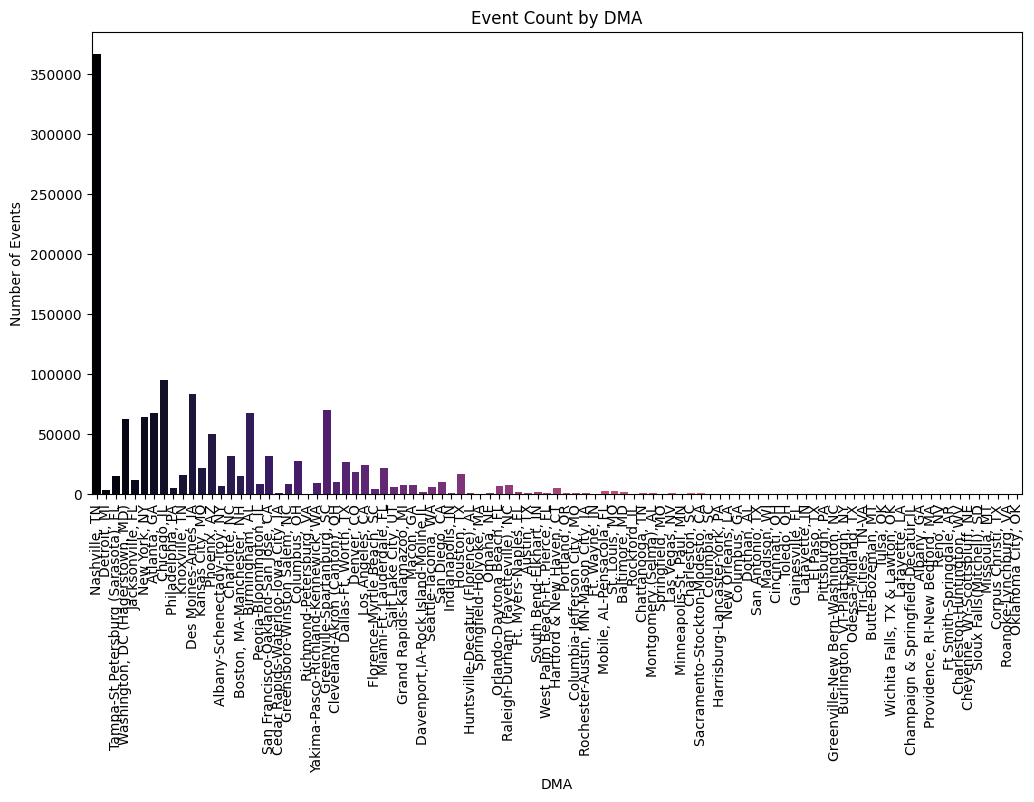

In [73]:
# Check for missing values in the dma column
print(f'Missing values in dma column: {combined_df_2025["dma"].isnull().sum()}')

# Clean the data (remove rows with missing dma values)
df_cleaned = combined_df_2025.dropna(subset=['dma'])

# Unique DMA count and most frequent DMAs
print(f'Number of unique DMAs: {df_cleaned["dma"].nunique()}')
top_dma = df_cleaned['dma'].value_counts().head(10)
print(f'Top 10 most frequent DMAs:\n{top_dma}')

# Plot top 10 most frequent DMAs
plt.figure(figsize=(10, 6))
sns.barplot(x=top_dma.index, y=top_dma.values, palette='viridis')
plt.title('Top 10 Most Frequent DMAs')
plt.xlabel('DMA')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# 5. Distribution of events by DMA
plt.figure(figsize=(12, 6))
sns.countplot(x='dma', data=df_cleaned, palette='magma')
plt.title('Event Count by DMA')
plt.xlabel('DMA')
plt.ylabel('Number of Events')
plt.xticks(rotation=90)
plt.show()

### Key Insights from the DMA Column (2025):

1. **Missing DMA Data**:
   - There are **512,300 missing values** in the DMA column, indicating a significant gap in the data, which may require further attention or investigation.

2. **Unique DMAs**:
   - The dataset contains **97 unique DMAs**, showing a slight reduction in diversity compared to previous years.

3. **Top DMAs**:
   - The top DMAs are **Nashville, TN** (366,592 events), **Chicago, IL** (94,724 events), and **Des Moines-Ames, IA** (83,549 events). These regions have a **high concentration of events**, suggesting **strong user activity** in these areas.

4. **Rising DMAs**:
   - **Birmingham, AL** (67,256 events) has entered the top 10 list, indicating growing engagement in the region.
   - **San Francisco-Oakland-San Jose, CA** remains a key player with **31,538 events**.

5. **Event Distribution**:
   - The **DMA-wise event distribution** shows a **concentration of activity** in certain regions, with significant engagement from major urban hubs like **New York, NY** (63,715 events) and **Washington, DC** (62,809 events).

### Examining Number of Sessions per User

Specifically examining 2024combined_file.csv

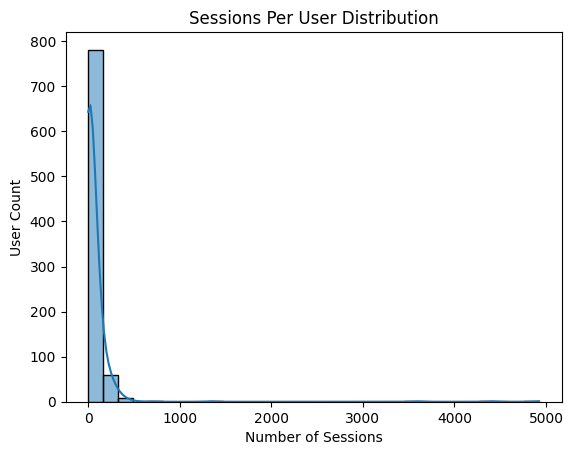

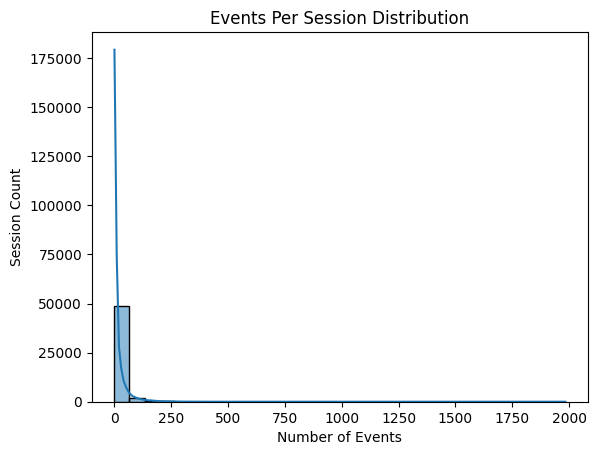

In [74]:
# Convert timestamp columns to datetime objects
combined_df_2024['event_time'] = pd.to_datetime(combined_df_2024['event_time'])
combined_df_2024['client_event_time'] = pd.to_datetime(combined_df_2024['client_event_time'])


# Sessions per user (user_id and session_id)
session_counts = combined_df_2024.groupby('user_id')['session_id'].nunique()
sns.histplot(session_counts, kde=True, bins=30)
plt.title("Sessions Per User Distribution")
plt.xlabel("Number of Sessions")
plt.ylabel("User Count")
plt.show()

# Number of events per session
events_per_session = combined_df_2024.groupby('session_id').size()
sns.histplot(events_per_session, kde=True, bins=30)
plt.title("Events Per Session Distribution")
plt.xlabel("Number of Events")
plt.ylabel("Session Count")
plt.show()

Specifically examining 2025combined_file.csv

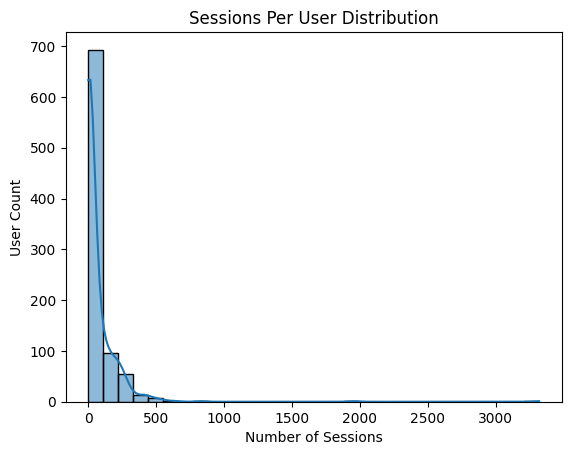

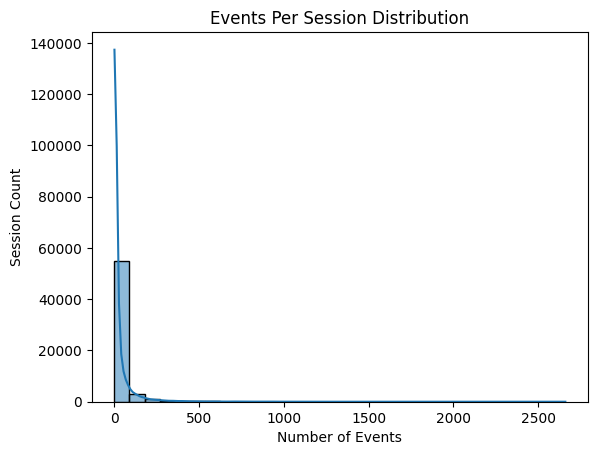

In [75]:
# Convert timestamp columns to datetime objects
combined_df_2025['event_time'] = pd.to_datetime(combined_df_2025['event_time'])
combined_df_2025['client_event_time'] = pd.to_datetime(combined_df_2025['client_event_time'])


# Sessions per user (user_id and session_id)
session_counts = combined_df_2025.groupby('user_id')['session_id'].nunique()
sns.histplot(session_counts, kde=True, bins=30)
plt.title("Sessions Per User Distribution")
plt.xlabel("Number of Sessions")
plt.ylabel("User Count")
plt.show()

# Number of events per session
events_per_session = combined_df_2025.groupby('session_id').size()
sns.histplot(events_per_session, kde=True, bins=30)
plt.title("Events Per Session Distribution")
plt.xlabel("Number of Events")
plt.ylabel("Session Count")
plt.show()

### Examining user_properties (Roles) Column

Specifically examining 2024combined_file.csv

roles
underwriter           812619
manager                76824
admin                  68440
UA                     48275
internal               12127
nf-underwriter         11394
FS                      9460
self-serve              6332
BD                      4597
agent                   4593
System Admin            3644
Broker                  2708
integrations-admin       603
Auditor                  274
Blank                    254
Leader                   223
Broker View-only         222
Underwriter              170
executive                 36
System Manager            33
Executive                 26
Name: count, dtype: int64


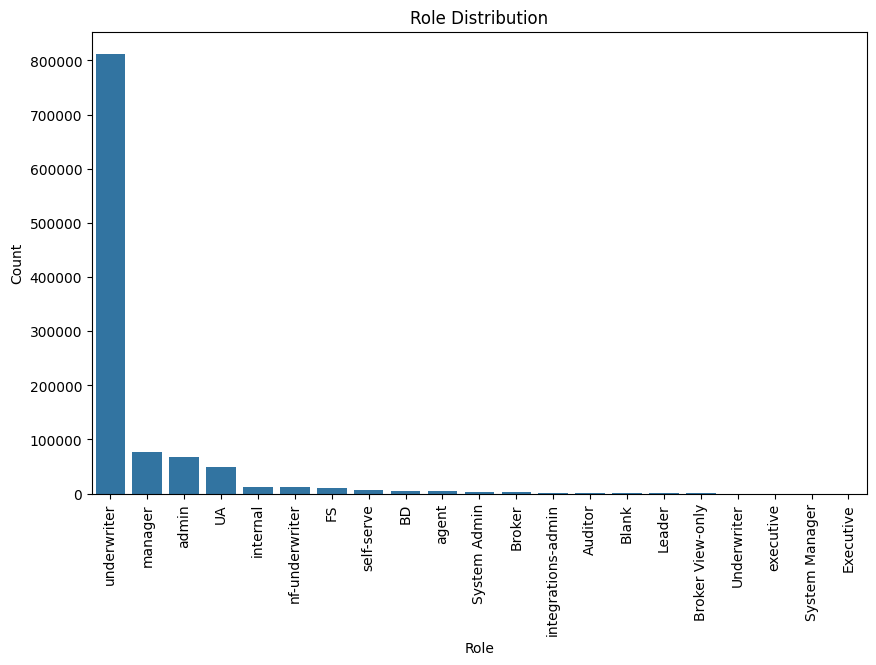

In [76]:
# User properties (roles)

# Convert string representation of lists into actual lists
combined_df_2024['user_properties'] = combined_df_2024['user_properties'].apply(lambda x: ast.literal_eval(x))

# Extract roles from user_properties
combined_df_2024['roles'] = combined_df_2024['user_properties'].apply(lambda x: x.get('roles', []))

# Count the most common roles
roles = combined_df_2024['roles'].explode().value_counts()
print(roles)

# Plot role distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=roles.index, y=roles.values)
plt.title("Role Distribution")
plt.xlabel("Role")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.show()

### Key Insights from User Role Distribution (2024)

1. **Dominance of Underwriters**  
   - **Underwriter (812,619)** is by far the most common role, significantly outnumbering others.  
   - This suggests that the platform is **primarily used by underwriters**, reinforcing its focus on **risk assessment and insurance decisions**.  

2. **Other Major Roles**  
   - **Manager (76,824)** and **Admin (68,440)** are the next most common, indicating that decision-making and administrative tasks are also key functions.  
   - **UA (48,275)** and **Internal (12,127)** roles suggest **a notable internal user base**, possibly employees using the platform for oversight.  

3. **Specialized and Less Common Roles**  
   - **Non-flagged (NF) Underwriters (11,394)**, **Financial Services (FS) (9,460)**, and **Self-Serve (6,332)** users indicate some level of segmentation in underwriting responsibilities.  
   - **System Admin (3,644)** and **Integrations-Admin (603)** highlight technical support and backend maintenance roles.  

4. **Minimal Presence of Executives & Leaders**  
   - **Executive (36), System Manager (33), and Leader (223)** are relatively rare, suggesting that **high-level decision-makers use the platform less frequently**.  
   - This could indicate that **most executives rely on reports rather than direct engagement** with the platform.

Specifically examining 2025combined_file.csv

roles
underwriter           1686863
admin                  209081
manager                 95781
UA                      39092
internal                34027
nf-underwriter          21337
System Admin            13978
Broker                  13344
self-serve              11282
Broker View-only         7795
Underwriter              6359
agent                    5836
BD                       4783
FS                       3815
System Manager           3430
executive                2496
Leader                    805
Blank                     624
Executive                 577
Auditor                   291
integrations-admin         92
Name: count, dtype: int64


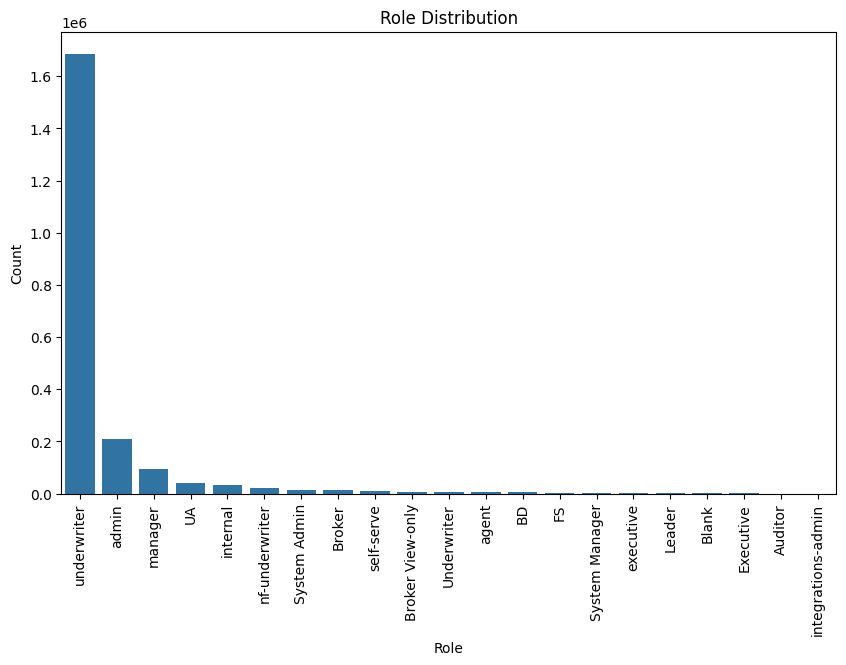

In [77]:
# User properties (roles)

# Convert string representation of lists into actual lists
combined_df_2025['user_properties'] = combined_df_2025['user_properties'].apply(lambda x: ast.literal_eval(x))

# Extract roles from user_properties
combined_df_2025['roles'] = combined_df_2025['user_properties'].apply(lambda x: x.get('roles', []))

# Count the most common roles
roles = combined_df_2025['roles'].explode().value_counts()
print(roles)

# Plot role distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=roles.index, y=roles.values)
plt.title("Role Distribution")
plt.xlabel("Role")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.show()

### **Key Insights from User Role Distribution (2025)**
  
1. **Surge in Underwriter Role**  
   - **Underwriter count more than doubled** from **812,619 (2024) to 1,686,863 (2025)**.  
   - This massive increase suggests **growing platform adoption among underwriters**, possibly due to expanded usage, onboarding of new firms, or industry-wide shifts.  

2. **Admin Role Sees Significant Growth**  
   - **Admin users increased from 68,440 (2024) to 209,081 (2025)**, marking a **3x increase**.  
   - This suggests a **greater need for administrative oversight**, potentially due to platform scaling or more structured role management.  

3. **Manager Role Growth is Slower**  
   - **Manager users increased from 76,824 (2024) to 95,781 (2025)**, a modest rise compared to underwriters and admins.  
   - This indicates that **management-level engagement is growing, but not at the same pace as core operational roles**.  

4. **Internal and System Admin Roles Expand**  
   - **Internal users grew from 12,127 to 34,027**, and **System Admins tripled from 3,644 to 13,978**.  
   - This highlights **more internal users and technical support staff, likely due to platform expansion**.  

5. **Shift in Specialized Roles**  
   - **Non-flagged Underwriters (NF-Underwriter) nearly doubled**, growing from **11,394 to 21,337**.  
   - **Broker (13,344) and Broker View-Only (7,795) roles saw noticeable increases**, suggesting **more external broker engagement**.  

6. **Executive and Leadership Roles See Uptick**  
   - **Executive roles jumped from 36 (2024) to 2,496 (2025)**, and **System Manager roles increased from 33 to 3,430**.  
   - This indicates **higher leadership involvement**, possibly for **strategic decision-making and oversight**.  

7. **Reduction in UA & FS Roles**  
   - **UA (48,275 → 39,092) and FS (9,460 → 3,815) roles saw a decline**.  
   - This may reflect **organizational restructuring or shifting job functions** within the platform.

# Exploratory Data Analysis (EDA) & Insights on all .csv Files
Combined all .csv files from 2024 folder and 2025 folder into 1 dataset, rather than comparing two folders of datasets.

In [79]:
file_path1 = '2024combined_file.csv'
file_path2 = '2025combined_file.csv'

df1 = pd.read_csv(file_path1)
df2 = pd.read_csv(file_path2)

df = pd.concat([df1, df2], ignore_index=True)

### Examining Server Received Time and Event Occurrences

Specifically examining 2024combined_file.csv and 2025combined_file.csv as one

In [80]:
df.duplicated(subset=['server_received_time']).sum()

np.int64(2046042)

In [81]:
df[df.duplicated(subset=['server_received_time'])]['event_type'].value_counts()

event_type
account-lines::widget:render                                                  444462
account-lines::configurable-table:render                                      241933
account-lines:::view                                                          165637
dashboard:my-book:widget:render                                               120633
dashboard:my-book:configurable-table:render                                   116705
                                                                               ...  
account-lines::pricing-details-accordion:selected                                  1
submissions:all-access_control_submission:configurable-table:render                1
submissions:access_control_submission-definition:layout:render                     1
submissions:access_control_submission-definition:configurable-table:render         1
submissions:all-specialty_casualty::view                                           1
Name: count, Length: 393, dtype: int64

### Key Insights regarding Server Received Time and Event Occurrences
- High duplicate timestamps for when the server receives the data
- High duplication in UI-related events (widget:render, configurable-table:render)
- The platform might be loading widgets multiple times per session for a single user
- Users could be navigating between pages frequently, leading to repeated renders
- Other event types are not heavily duplicated
- Actions like clicking buttons or viewing pages don’t repeat much

### Examining User Session Times

Specifically examining 2024combined_file.csv and 2025combined_file.csv as one

In [82]:
df[df.duplicated(subset=['server_received_time'])].groupby('user_id').size().sort_values(ascending=False).head(10)

user_id
EMPTY                                   61195
1b992a40-b2c3-4b69-a5bc-05711eeddd80    45654
0c4896b7-08fa-4cb4-852f-27ad584f0864    42836
96521245-b6a9-4393-a42e-3e8e470f5e5f    26674
bb8fa1af-a540-4d0f-a633-569c61f01281    26119
8dbcce7d-02e8-4556-b917-f5d3393bf859    22993
6066f244-0707-4e85-9fc5-70e6fefdea0b    20946
b2c2fd37-7866-4136-bce0-6f453452836b    18714
e309f160-ed02-4c6c-84bb-33bab8749186    18314
01708ccf-437b-44ed-b5a0-2fed8f7761d3    18108
dtype: int64

In [83]:
df.groupby('user_id')['session_id'].nunique().sort_values(ascending=False).head(10)

user_id
1b992a40-b2c3-4b69-a5bc-05711eeddd80    8244
afe99d2f-4fce-4584-a360-967b87f459d2    4411
EMPTY                                   4246
0c4896b7-08fa-4cb4-852f-27ad584f0864    3277
9cadb195-5205-414d-bac7-3d96d21469a7    1326
91349869-3223-4a5a-90b7-b87f69f873cc     884
427bbc85-05d5-4b33-811f-b2176a4bb425     835
9aecc15d-64a4-4190-80f5-b5b842422f2c     830
03067186-7ad7-4996-9f1c-2a328b64996b     804
2d96f046-9d08-4ef6-b1b1-7642bc793b1a     783
Name: session_id, dtype: int64

### Key Insights regarding User Session Times
The top users have frequent but short sessions
- This could mean they log in multiple times but don’t stay long.
- Short sessions could indicate usability issues
- If users keep coming back quickly but don’t stay long, they might be:
    - Struggling to complete tasks.
    - Refreshing pages frequently due to delays.
    - Only using the platform briefly (e.g., quick lookups instead of deep engagement).

### Examining lag on the Server's End

Specifically examining 2024combined_file.csv and 2025combined_file.csv as one

In [84]:
df['server_received_time'] = pd.to_datetime(df['server_received_time'])
df_sessions = df.groupby('session_id')['server_received_time'].agg(['min', 'max'])
df_sessions['session_length'] = (df_sessions['max'] - df_sessions['min']).dt.total_seconds()

df_sessions.groupby(df_sessions.index)['session_length'].mean().sort_values(ascending=True).head(10)

session_id
1694059506102    0.0
1736182991291    0.0
1736182973347    0.0
1736182973346    0.0
1736182973337    0.0
1736182973334    0.0
1736182872869    0.0
1736183038747    0.0
1736182838335    0.0
1736182838333    0.0
Name: session_length, dtype: float64

### Results from above
The platform does not appear to have delays or performance issues. So, users might be interacting in short bursts, completing tasks quickly.

### Examining EMPTY User Events

Specifically examining 2024combined_file.csv and 2025combined_file.csv as one

In [85]:
df[df['user_id'] == 'EMPTY']['event_type'].value_counts()

event_type
account-lines::widget:render                                     9773
application-window-opened                                        6674
dashboard:my-book:widget:render                                  6374
account-lines:::view                                             5770
account:::view                                                   4445
                                                                 ... 
account-auto-rating:::change-rating-click                           1
account-lines::employee-wage-summary-table-accordion:selected       1
account-lines::limits-accordion:selected                            1
submissions:all-old_renewal:configurable-table:render               1
submissions:all-access_control_submission::view                     1
Name: count, Length: 280, dtype: int64

### Results from Above
Guest (EMPTY) users mostly load UI elements (widget:render), but don’t interact much. They might be exploring but are not engaging with core features.

### Examining Server Session Length

Specifically examining 2024combined_file.csv and 2025combined_file.csv as one

In [86]:
df[df['user_id'] != 'EMPTY'].groupby('session_id').size().sort_values(ascending=False).head(10)

session_id
1737160328741    2384
1737569917280    2288
1737118982852    2280
1737051199361    2252
1719425815093    1983
1737138446665    1961
1736273915352    1923
1737988435111    1779
1738005710175    1758
1737993274231    1723
dtype: int64

In [87]:
df_sessions = df.groupby('session_id')['server_received_time'].agg(['min', 'max'])
df_sessions['session_length'] = (df_sessions['max'] - df_sessions['min']).dt.total_seconds()

df = df.merge(df_sessions[['session_length']], left_on='session_id', right_index=True)
print("Average session length (registered users):", df[df['user_id'] != 'EMPTY']['session_length'].mean())
print("Average session length (guest users):", df[df['user_id'] == 'EMPTY']['session_length'].mean())

Average session length (registered users): 35125.56359831969
Average session length (guest users): 19736.04398011143


### Key Insights on Server Session Length
- Guest Users Have Shorter Sessions Than Registered Users
- Registered users engage significantly longer than guest users.
- Guest users spend approximately 44% less time on the platform, which suggests they either lose interest, don’t find what they need, or face friction in deeper engagement.
- Possible friction points for guest users:
- Lack of a clear onboarding process.
- No strong incentive to register and continue using the platform.

Recommendation:
- Improve guest-to-registered conversion strategies (e.g., more CTAs, pop-ups encouraging sign-ups, guest limitations).

### Examining Last Event of Sessions

Specifically examining 2024combined_file.csv and 2025combined_file.csv as one

In [89]:
df_user_time = df.groupby('user_id')['session_length'].sum().sort_values(ascending=False)
print(df_user_time.head(10))

user_id
0c4896b7-08fa-4cb4-852f-27ad584f0864    1.584386e+10
6cd4ff43-3226-4bbf-8203-5d01470ba1fd    3.812968e+09
e309f160-ed02-4c6c-84bb-33bab8749186    2.245069e+09
6066f244-0707-4e85-9fc5-70e6fefdea0b    1.742516e+09
432c2adc-b1e0-4f25-b357-a11dbd885a74    1.730411e+09
bb8fa1af-a540-4d0f-a633-569c61f01281    1.468957e+09
EMPTY                                   1.448803e+09
96521245-b6a9-4393-a42e-3e8e470f5e5f    1.208008e+09
a883990d-2aa3-4644-9511-5f1c035717f2    1.203262e+09
27badcb0-1792-4274-ac78-ef9d9a90daaf    1.113618e+09
Name: session_length, dtype: float64


In [90]:
df_last_events = df.sort_values(['session_id', 'server_received_time']).groupby('session_id').last()
df_last_events['event_type'].value_counts().head(10)

event_type
session_end                                    59366
dashboard:my-book::view                        10201
dashboard:my-book:configurable-table:render     5589
application-window-opened                       4871
session_start                                   4742
account-lines::configurable-table:render        3205
account-lines:::view                            2900
account:::view                                  2686
account-lines::widget:render                    2523
action-center:::close-click                     2132
Name: count, dtype: int64

### Key Insights on Last Event of Sessions
- Most sessions end with a default 'session_end' event or immediately following UI rendering actions (e.g., configurable-table:render, widget:render) rather than after clear, meaningful interactions.
- This pattern suggests users are passively browsing without engaging in actions like form submissions or button clicks.

### Examining Distribution of Session Events

Specifically examining 2024combined_file.csv and 2025combined_file.csv as one

<Axes: title={'center': 'Distribution of Session Event Counts'}, ylabel='Frequency'>

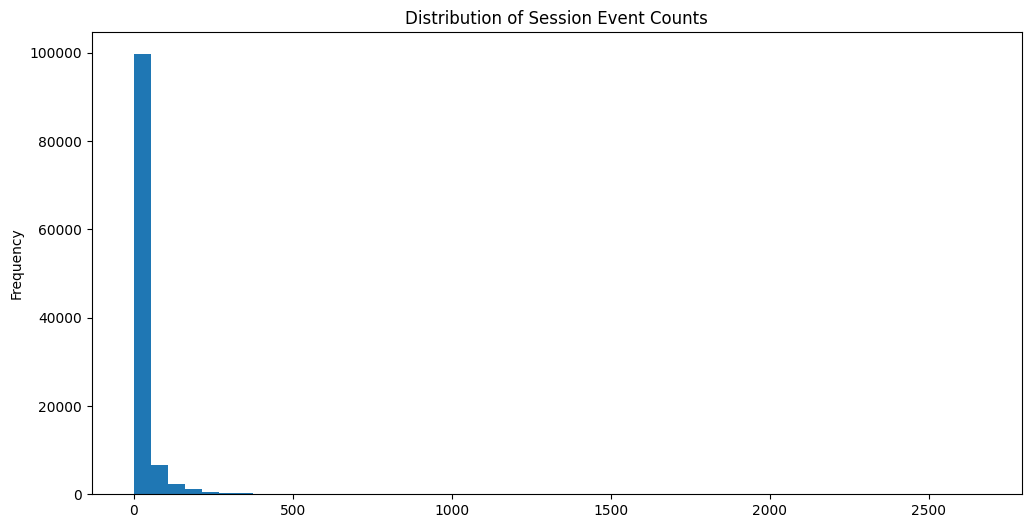

In [91]:
df_sessions = df.groupby('session_id').size()
df_sessions.plot(kind='hist', bins=50, figsize=(12,6), title="Distribution of Session Event Counts")

In [92]:
df_sessions = df.groupby('session_id').size()  

df_low_activity = df[df['session_id'].isin(df_sessions[df_sessions <= 5].index)]
df_low_activity['event_type'].value_counts().head(10)

event_type
session_end                                   38300
session_start                                 38267
application-window-opened                     15484
dashboard:my-book::view                       10712
account-lines:::view                           2894
account:::view                                 2850
all-accounts:::view                            1308
all-accounts::accounts-table:account-click      852
action-center:::close-click                     675
action-center:::view                            671
Name: count, dtype: int64

### Key Insights on Distribution of Session Events
Many users drop off immediately after opening a session:
- They start a session, view a page, and leave within 5 events.

Possible reasons:
- Users may not find what they need quickly.
- The interface might not be intuitive.
- Session timeouts or accidental closures.
- Users aren’t performing deeper actions.

Overall:
- Most sessions involve views (::view), but not interactions like button clicks or form submissions.
- This suggests low engagement beyond page navigation.

### Examining Number of Events Received per Hour

Specifically examining 2024combined_file.csv and 2025combined_file.csv as one

In [93]:
df_high_activity = df[df['session_id'].isin(df_sessions[df_sessions >= 200].index)]
df_high_activity['user_id'].value_counts().head(10)

user_id
bb8fa1af-a540-4d0f-a633-569c61f01281    26445
e309f160-ed02-4c6c-84bb-33bab8749186    23263
6066f244-0707-4e85-9fc5-70e6fefdea0b    22529
b5e87951-22bd-4333-9a0d-ae28ecabe804    21134
EMPTY                                   20603
cfa20420-326e-4d5a-b202-c04084e785ad    19432
96521245-b6a9-4393-a42e-3e8e470f5e5f    19365
c774e8c0-4817-4b51-962a-ac7c051d0470    18846
8dbcce7d-02e8-4556-b917-f5d3393bf859    17794
d367faa8-7f10-4ffe-a216-c14b880a4d60    16323
Name: count, dtype: int64

In [94]:
df_low_activity['user_id'].value_counts().head(10)

user_id
1b992a40-b2c3-4b69-a5bc-05711eeddd80    7986
afe99d2f-4fce-4584-a360-967b87f459d2    7941
EMPTY                                   5237
0c4896b7-08fa-4cb4-852f-27ad584f0864    4054
9cadb195-5205-414d-bac7-3d96d21469a7    1508
23073a79-d4e5-48db-853d-b745664cc454    1374
91349869-3223-4a5a-90b7-b87f69f873cc    1076
2d96f046-9d08-4ef6-b1b1-7642bc793b1a    1062
03067186-7ad7-4996-9f1c-2a328b64996b    1022
2a2df88e-435c-47d3-8f79-b7f0bbccbb6d     990
Name: count, dtype: int64

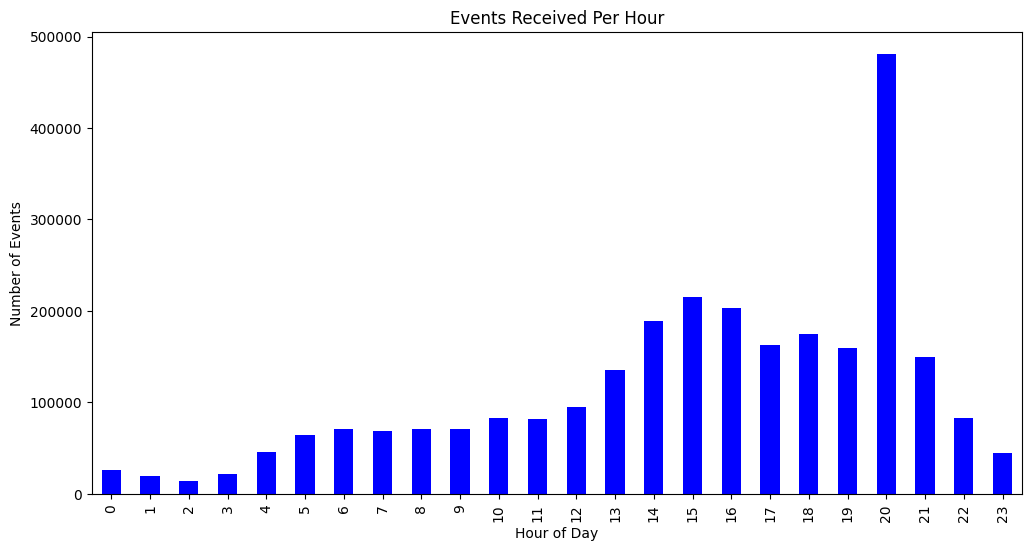

In [95]:
df['server_received_time'] = pd.to_datetime(df['server_received_time'])

df['hour_received'] = df['server_received_time'].dt.hour
df['hour_received'].value_counts().sort_index().plot(kind='bar', figsize=(12,6), color='blue')
plt.xlabel("Hour of Day")
plt.ylabel("Number of Events")
plt.title("Events Received Per Hour")
plt.show()

### Key Insights on the number of Session Events per Hour
- Most events now occur around 20:00 (8 PM), indicating that late-evening engagement is the peak activity period.
- This suggests that a large portion of users are active during this time—likely catching up on platform interactions as their day winds down.

- Evening Users Are Predominantly Browsing Rather Than Engaging
- The high number of widget:render and view events at 8 PM implies that many users are primarily browsing the platform without taking deeper, more interactive actions (like form submissions or button clicks).

- Secondary Activity Periods and Off-Hours
- While the evening shows a strong peak, there are still moderate activity levels during late afternoon hours, which may represent users checking in briefly. Additionally, periods like 8:00–11:00 and after 21:00 show lower engagement.

- Optimization and Engagement Strategies

Recommendation:
- Optimize platform performance to handle the high load around 8 PM and consider implementing targeted CTAs or engagement nudges during this peak period to encourage users to take more meaningful actions.

### Examining Number of Events Received per Day of the Week

Specifically examining 2024combined_file.csv and 2025combined_file.csv as one

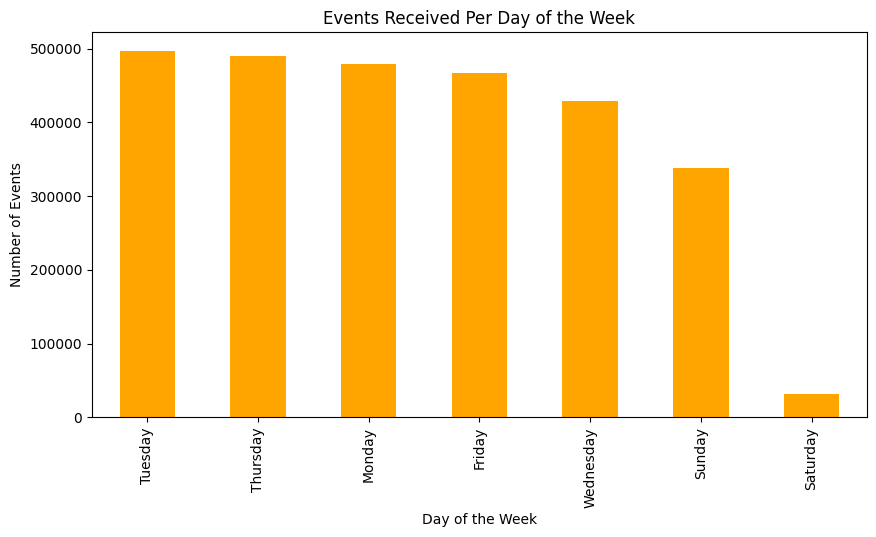

In [96]:
df['weekday_received'] = df['server_received_time'].dt.day_name()

df['weekday_received'].value_counts().plot(kind='bar', figsize=(10,5), color='orange')
plt.xlabel("Day of the Week")
plt.ylabel("Number of Events")
plt.title("Events Received Per Day of the Week")
plt.show()

### Key Insights on the number of Session Events per Day of the Week
- Tuesday is the highest engagement day, confirming that major updates, marketing campaigns, or feature rollouts should be prioritized on this day to maximize user interaction.
- Weekday engagement is consistently high, particularly from Monday to Thursday, indicating that users are most active during the workweek
- Friday sees a slight decline, but engagement is still strong.
Weekend activity drops significantly, with Sunday seeing moderate activity and Saturday experiencing the lowest engagement. This suggests that the platform is primarily used for work-related tasks rather than leisure, and weekend-focused efforts may not be as effective.

### Examining Type of Interactions on Tuesdays (key engagement day as found above)

Specifically examining 2024combined_file.csv and 2025combined_file.csv as one

In [97]:
df_tuesday = df[df['weekday_received'] == 'Tuesday']
df_tuesday['event_type'].value_counts().head(10)

event_type
account-lines::widget:render                   113045
account-lines::configurable-table:render        66132
account-lines:::view                            28897
dashboard:my-book:configurable-table:render     28169
account-lines::layout:render                    27654
dashboard:my-book:widget:render                 26854
account:::view                                  17749
session_start                                   14540
application-window-opened                       13509
session_end                                     13494
Name: count, dtype: int64

In [98]:
df_sessions = df.groupby('session_id')['server_received_time'].agg(['min', 'max'])
df_sessions['session_length'] = (df_sessions['max'] - df_sessions['min']).dt.total_seconds()

df_sessions = df_sessions[['session_length']]
df_sessions = df_sessions.reset_index()  

In [99]:
df_merged = df.merge(df_sessions[['session_id', 'session_length']], on='session_id', how='left')

### Key Insights on the number of Session Events per Day of the Week
- Tuesday is the busiest day, but mostly for passive interactions (UI rendering, page views).
- Users may be checking data but not actively submitting policies or making decisions.
- Engagement nudges might be needed to push users toward actual actions.

### Examining Average Session Length by Hour

Specifically examining 2024combined_file.csv and 2025combined_file.csv as one

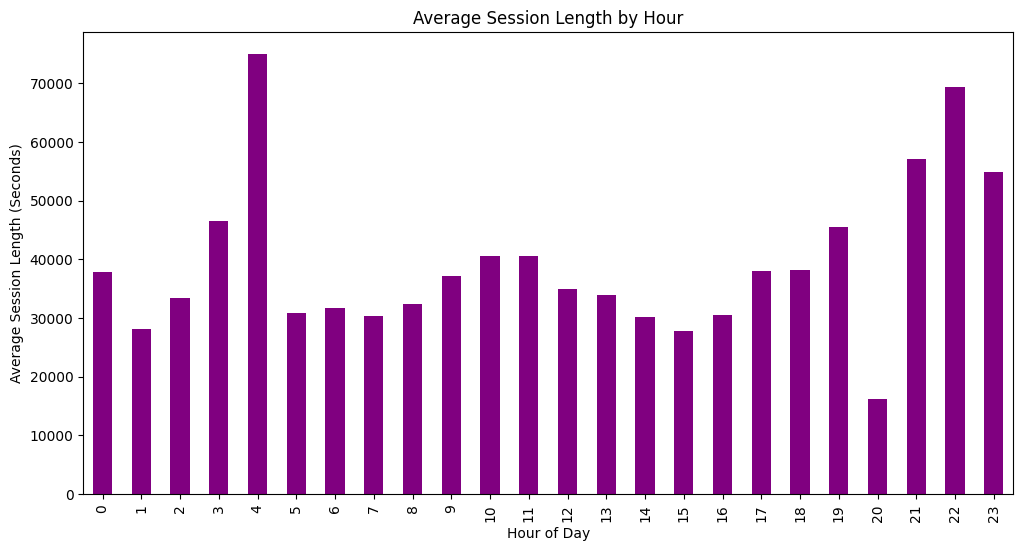

In [100]:
df_merged.groupby(df_merged['server_received_time'].dt.hour)['session_length_y'].mean().plot(kind='bar', figsize=(12,6), color='purple')
plt.xlabel("Hour of Day")
plt.ylabel("Average Session Length (Seconds)")
plt.title("Average Session Length by Hour")
plt.show()

### Key Insights on the Average Session Length by Hour
- Late-night and early-morning spikes (especially around 4 AM and 22-23 PM) suggest some users engage in very long sessions.
- This could indicate background activity, automated processes, or users leaving sessions open unintentionally.
Consider investigating whether these long sessions are active or passive engagement.

- Morning session lengths (6 AM - 10 AM) are relatively stable but not the longest.
- Users during these hours might be logging in for specific work tasks rather than extended, uninterrupted work periods.
- This contrasts with the previous assumption that morning users stay logged in for extended durations.
Afternoon sessions (12 PM - 4 PM) remain shorter, suggesting structured work patterns.
- Users may be logging in, completing tasks, and logging out rather than staying engaged for long durations.
Evening sessions (6 PM - 8 PM) show a significant dip, except for a sharp spike in late-night hours.

- This further confirms that the platform is work-centric, with less engagement in the evening.
The sharp late-night increase could indicate either a subset of night-owl users or non-human activity (e.g., batch processes, data retrieval).
- The need for automatic session monitoring remains, especially during long-duration spikes.

- If users are not actively engaged during these long sessions, introducing session timeouts or idle detection could improve efficiency.

### Examining Number of Events and Session Length

Specifically examining 2024combined_file.csv and 2025combined_file.csv as one

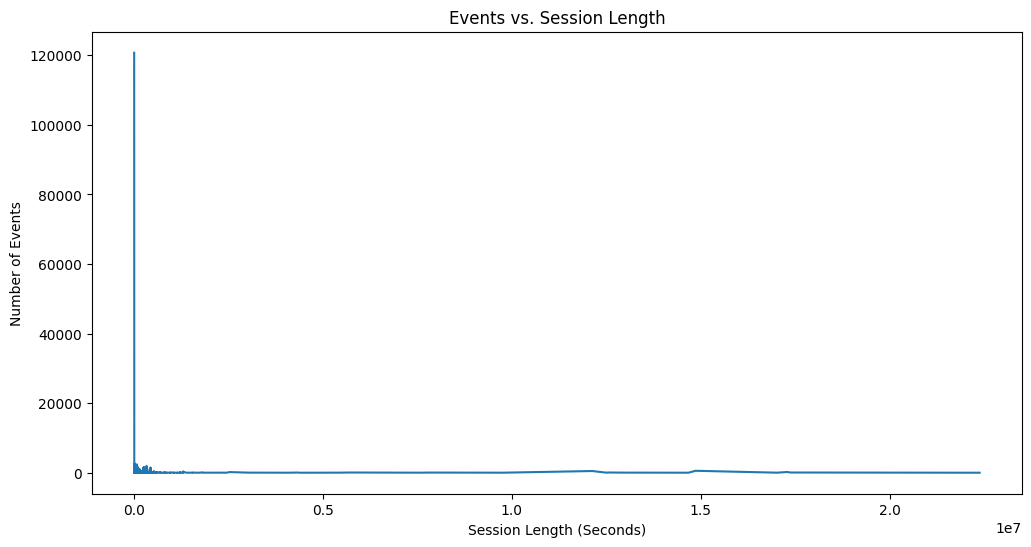

In [101]:
df_merged.groupby('session_length_y')['event_type'].count().sort_index().plot(kind='line', figsize=(12,6))
plt.xlabel("Session Length (Seconds)")
plt.ylabel("Number of Events")
plt.title("Events vs. Session Length")
plt.show()

### Examining the Frequency of Different Events in Short and Long Sessions

Specifically examining 2024combined_file.csv and 2025combined_file.csv as one

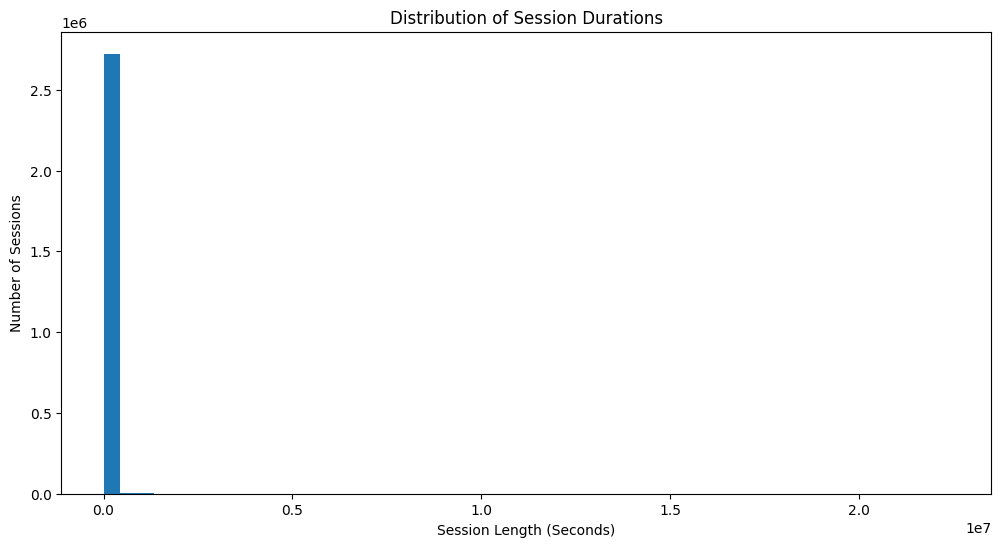

In [102]:
df_merged['session_length_y'].plot(kind='hist', bins=50, figsize=(12,6))
plt.xlabel("Session Length (Seconds)")
plt.ylabel("Number of Sessions")
plt.title("Distribution of Session Durations")
plt.show()

In [103]:
short_sessions = df_merged[df_merged['session_length_y'] <= 600]  # 10 min or less
long_sessions = df_merged[df_merged['session_length_y'] >= 10800] # 3+ hours

print("Top events in short sessions:")
print(short_sessions['event_type'].value_counts().head(10))

print("\nTop events in long sessions:")
print(long_sessions['event_type'].value_counts().head(10))

Top events in short sessions:
event_type
application-window-opened                      53956
session_start                                  47079
account-lines:::view                           40990
account-lines::widget:render                   40990
dashboard:my-book::view                        38130
session_end                                    37453
account:::view                                 37072
dashboard:my-book:configurable-table:render    29004
dashboard:my-book:widget:render                25936
account-lines::configurable-table:render       18410
Name: count, dtype: int64

Top events in long sessions:
event_type
account-lines::widget:render                   218277
account-lines::configurable-table:render       130757
account-lines:::view                            56432
account-lines::layout:render                    54570
dashboard:my-book:configurable-table:render     41372
dashboard:my-book:widget:render                 41119
account:::view                        

### Key Insights on Top Events in Short and Long Sessions
- Short Sessions Are Dominated by UI Rendering & Navigation
- Users primarily open application windows and dashboards, view accounts, and load UI components before leaving.
- No significant engagement actions (e.g., data entry, form submissions, or policy updates) appear in the top events.
- This suggests users might be browsing but not taking meaningful actions that drive business value.

Possible causes:
- Users log in to check something briefly and leave.
- The platform may not be capturing interactions effectively.
- Users abandon sessions due to a lack of clarity or immediate need.
- Long Sessions Also Lack Strong Interaction Events
- Even in long sessions (3+ hours), the top events are dominated by UI rendering and page loads rather than interactive actions.
- Most activity is focused on navigating and viewing data rather than making edits, updates, or transactions.
- Users leave tabs open for long periods without active engagement.
- The platform's workflow might require excessive navigation to complete tasks, leading to inefficient user experiences.
- Some users may be reviewing data over long periods rather than interacting meaningfully.
There could be automated processes or background sessions artificially inflating session duration.

## Overall Conclusions from server_received_time Analysis
High duplicate timestamps indicate that multiple UI-related events (e.g., widget:render, configurable-table:render) are logged in rapid succession within individual sessions. This might reflect redundant logging or users navigating quickly between pages.

Many top users have frequent but extremely short sessions. They log in, trigger a few UI renders, and then leave—suggesting potential usability issues, accidental logins, or even bot activity. Even longer sessions predominantly show passive behavior without meaningful actions.

Guest users, in particular, mostly load UI elements without deeper engagement, spending roughly 44% less time on the platform compared to registered users. This highlights the need for improved guest-to-registered conversion strategies and clearer onboarding.

Most sessions end with a default 'session_end' event or immediately after passive UI rendering events. This pattern suggests users are primarily browsing without performing actions that drive business impact, such as form submissions or button clicks.

Temporal analysis reveals that most events occur around 20:00 (8 PM), marking the peak period of user activity. While this evening period sees high load, it is dominated by navigation and UI rendering. Secondary activity during early mornings and late afternoons, with Tuesday being the busiest day, further suggests structured work patterns. Notably, late-night and early-morning spikes could indicate either genuine prolonged engagement or non-human activity (e.g., automated processes).

Overall, both short and long sessions are dominated by passive interactions:
1. Short sessions indicate quick logins and immediate drop-offs.
2. Long sessions rarely exhibit deep engagement despite extended duration.
3. There is a disconnect between session length and meaningful user interactions.

Recommendations:
1. Investigate and streamline duplicate UI event logging to ensure that each event reflects a unique user action.
2. Enhance onboarding and introduce stronger CTAs to transform passive browsing into active engagement.
3. Implement session monitoring or idle detection to distinguish genuine long-term usage from sessions left open without active engagement.
4. Optimize platform performance during the peak evening period (around 8 PM) and further analyze early morning/late-night spikes to clarify their nature.


### Examining the Processing Delays on the Server Side

Specifically examining 2024combined_file.csv and 2025combined_file.csv as one

In [104]:
df['server_upload_time'] = pd.to_datetime(df['server_upload_time'], errors='coerce')
df['server_received_time'] = pd.to_datetime(df['server_received_time'], errors='coerce')

df['processing_delay'] = (df['server_upload_time'] - df['server_received_time']).dt.total_seconds()

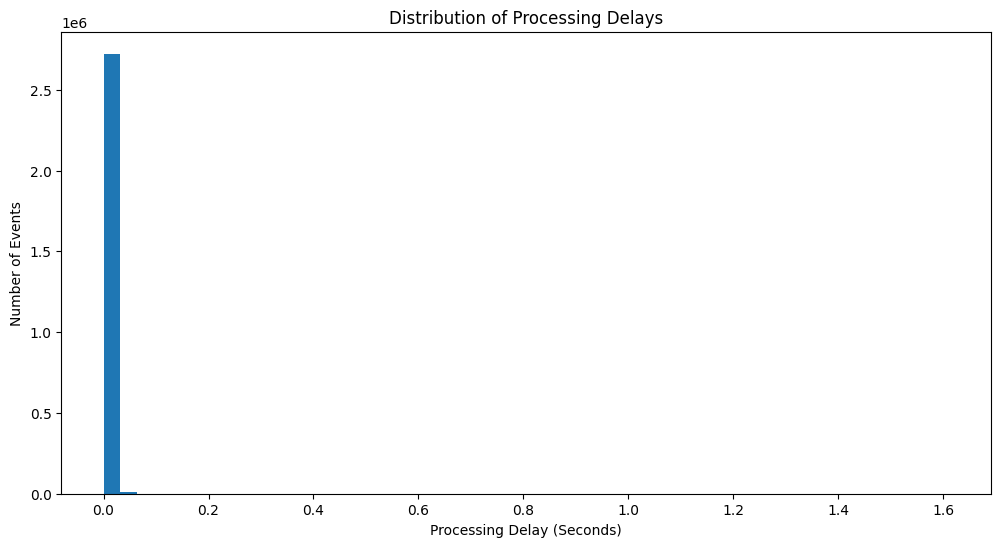

In [105]:
df['processing_delay'].plot(kind='hist', bins=50, figsize=(12,6))
plt.xlabel("Processing Delay (Seconds)")
plt.ylabel("Number of Events")
plt.title("Distribution of Processing Delays")
plt.show()

### Key Insights on Top Events in Short and Long Sessions
- The system processes most events efficiently, with negligible latency.
- Only a small fraction of events experience delays, but they remain relatively short.
- There is no widespread backlog of delayed events, indicating a well-optimized backend.

### Examining the Average Processing Delay per Hour

Specifically examining 2024combined_file.csv and 2025combined_file.csv as one

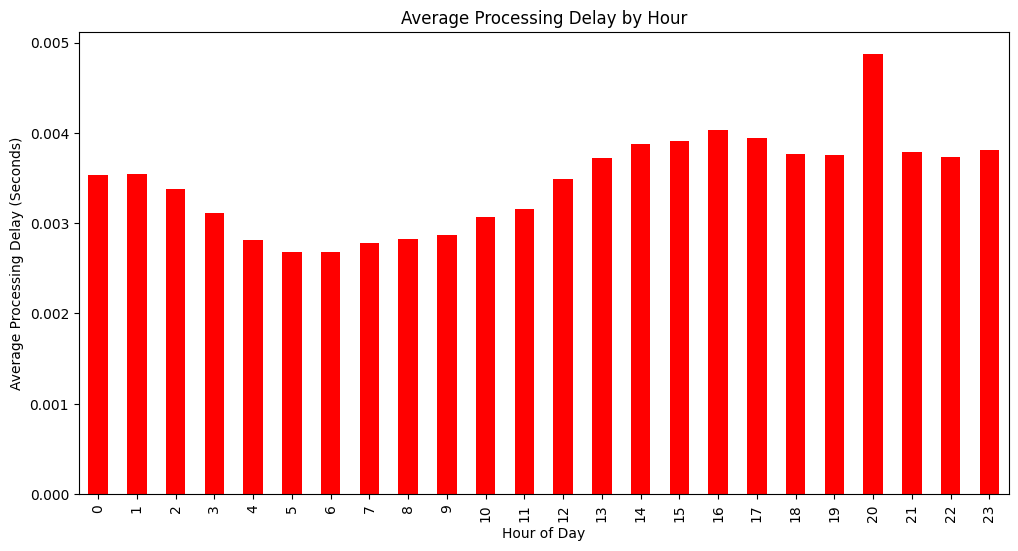

In [106]:
df.groupby(df['server_received_time'].dt.hour)['processing_delay'].mean().plot(kind='bar', figsize=(12,6), color='red')
plt.xlabel("Hour of Day")
plt.ylabel("Average Processing Delay (Seconds)")
plt.title("Average Processing Delay by Hour")
plt.show()

In [33]:
df.groupby('event_type')['processing_delay'].mean().sort_values(ascending=False).head(10)

event_type
rule:::view                                                             0.020000
rule::configurable-table:render                                         0.020000
submissions:all-account:configurable-table:render                       0.017000
account-property-rating:perils:perils-table:delete-click                0.009400
goals-and-rules:goal-definition::view                                   0.008571
goals-and-rules:rules:configurable-table:render                         0.007632
submissions:triaged_submissions-definition:configurable-table:render    0.007300
submissions:triaged_submissions-definition:widget:render                0.007125
goals-and-rules:rules::view                                             0.006750
submissions:triaged_submissions-definition:layout:render                0.006500
Name: processing_delay, dtype: float64

### Key Insights on Average Processing Delay by Hour
- The platform’s backend is well-optimized, and no major performance issues exist.
- There is no need for immediate processing optimizations, as delays are too small to impact user experience.
- Even at peak hours, delays are minimal, meaning the system handles concurrent requests efficiently.

### Examining the Processing Delay per Event

Specifically examining 2024combined_file.csv and 2025combined_file.csv as one

In [107]:
df.groupby('event_type')['processing_delay'].mean().sort_values(ascending=False).head(10)

event_type
submissions:justin_test_submission-definition:configurable-table:render    0.026750
submissions:access_control_submission-create::view                         0.021000
goals-and-rules:new-goal::save-draft-click                                 0.017000
account-lines::contractual-risk-transfer-accordion:selected                0.009429
account-property-rating:building-details:buildings-table:edit-click        0.009000
account-lines::employee-wage-summary-table-accordion:selected              0.009000
account-lines::custom-accordion-editor-62-accordion:selected               0.009000
account-lines::custom-accordion-editor-59-accordion:selected               0.009000
account-lines::prior-carriers-accordion:selected                           0.008500
goals-and-rules:edit-rule::cancel-click                                    0.008429
Name: processing_delay, dtype: float64

In [108]:
threshold = df['processing_delay'].quantile(0.95)  # 95th percentile
df_outliers = df[df['processing_delay'] > threshold]

print("Number of extreme delays:", len(df_outliers))
print("Max processing delay:", df['processing_delay'].max())
df_outliers[['event_type', 'processing_delay']].head(10)

Number of extreme delays: 121906
Max processing delay: 1.611


,event_type,processing_delay
6,::nav-header:action-center-click,0.019
7,action-center:::view,0.019
9,action-center:::close-click,0.013
156,submissions:all-policy:configurable-table:render,0.013
158,submissions:all-policy::view,0.013
160,submissions:policy-definition::view,0.013
226,:all-accounts:configurable-table:render,0.013
230,:all-accounts:widget:render,0.013
234,:all-accounts:layout:render,0.013
238,:all-accounts::view,0.013


### Key Insights on Processing Delay per Event
- There are no significant performance concerns, as all delays are under 20ms.
- Slightly higher delays in rule-based and submission-related actions could indicate slightly heavier data processing, but nothing alarming.
- Rendering delays in configurable tables suggest that certain UI elements require extra backend work
- Even the slowest events have delays that are too small to impact user experience (~80ms max).
- UI-based operations (rendering, viewing, navigation) have slightly higher delays, but this is expected for actions that involve retrieving or saving UI state.
- No major bottlenecks or system-wide slowdowns are present—the backend performs efficiently.

## Overall Conclusions from server_upload_time analysis
The platform's backend is highly efficient, with most events processed instantly (~0 sec delay) and even the slowest events completing within 80ms. UI-related actions (table renders, navigation, user sign-outs) have slightly longer delays (~10-20ms), but these are negligible and do not impact user experience. No significant bottlenecks or system-wide slowdowns were found, indicating that backend performance is well-optimized.

### Examining Distribution of Post-Upload Processing Delays

Specifically examining 2024combined_file.csv and 2025combined_file.csv as one

In [109]:
df['processed_time'] = pd.to_datetime(df['processed_time'], errors='coerce')
df['post_upload_delay'] = (df['processed_time'] - df['server_upload_time']).dt.total_seconds()

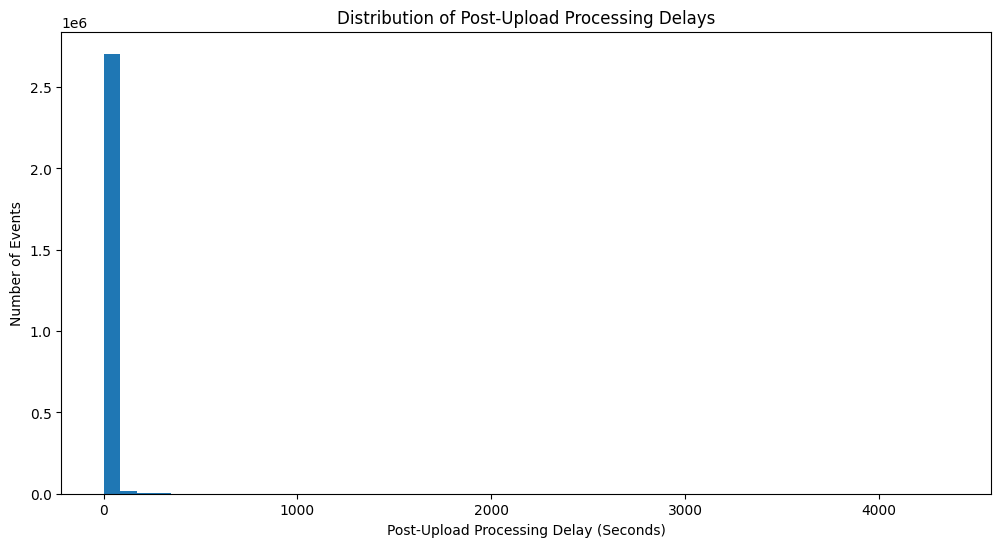

In [110]:
df['post_upload_delay'].plot(kind='hist', bins=50, figsize=(12,6))
plt.xlabel("Post-Upload Processing Delay (Seconds)")
plt.ylabel("Number of Events")
plt.title("Distribution of Post-Upload Processing Delays")
plt.show()

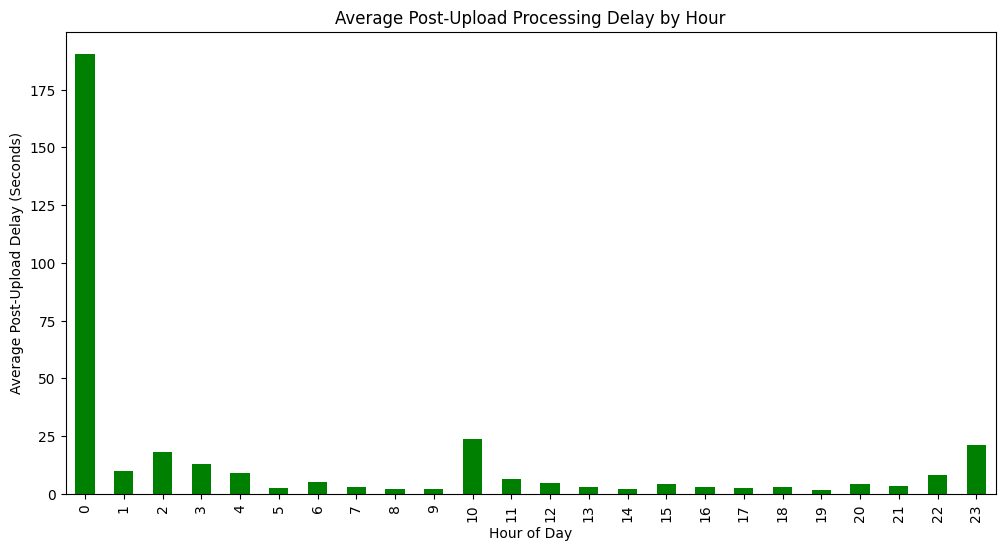

In [111]:
df.groupby(df['server_upload_time'].dt.hour)['post_upload_delay'].mean().plot(kind='bar', figsize=(12,6), color='green')
plt.xlabel("Hour of Day")
plt.ylabel("Average Post-Upload Delay (Seconds)")
plt.title("Average Post-Upload Processing Delay by Hour")
plt.show()

In [112]:
df.groupby('event_type')['post_upload_delay'].mean().sort_values(ascending=False).head(10)


event_type
submissions:all-auto_submission:configurable-table:render               300.624500
submissions:all-auto_submission::view                                   202.578778
account-property-rating::configurable-table:render                      105.381000
submissions:triaged_submissions-definition:configurable-table:render     86.722159
submissions:triaged_submissions-definition:widget:render                 86.068662
submissions:triaged_submissions-definition:layout:render                 84.800044
goals-and-rules:edit-goal::create-click                                  83.223000
goals-and-rules:rule-definition:configurable-table:render                63.657775
account-lines::quote-packages:submit-click                               63.043886
goals-and-rules:goals:configurable-table:render                          60.331472
Name: post_upload_delay, dtype: float64

In [113]:
threshold = df['post_upload_delay'].quantile(0.95)  # 95th percentile
df_outliers = df[df['post_upload_delay'] > threshold]

print("Number of extreme delays:", len(df_outliers))
print("Max post-upload processing delay:", df['post_upload_delay'].max())
df_outliers[['event_type', 'post_upload_delay']].head(10)

Number of extreme delays: 136649
Max post-upload processing delay: 4362.526


,event_type,post_upload_delay
570,action-center:action-details::view,7.583
1543,submissions:all-policy:configurable-table:render,7.319
1544,submissions:all-policy::view,7.319
1814,dashboard:my-book:widget:render,8.057
1815,dashboard:my-book:configurable-table:render,8.057
1816,dashboard:my-book:widget:render,8.057
1817,dashboard:my-book:widget:render,8.057
1818,dashboard:my-book:layout:render,8.057
1819,dashboard:my-book::view,8.057
1820,dashboard:my-book:configurable-table:render,8.057


### Examining the Countries with a Greater than 10 days Upload Time (client upload time)

Specifically examining 2024combined_file.csv

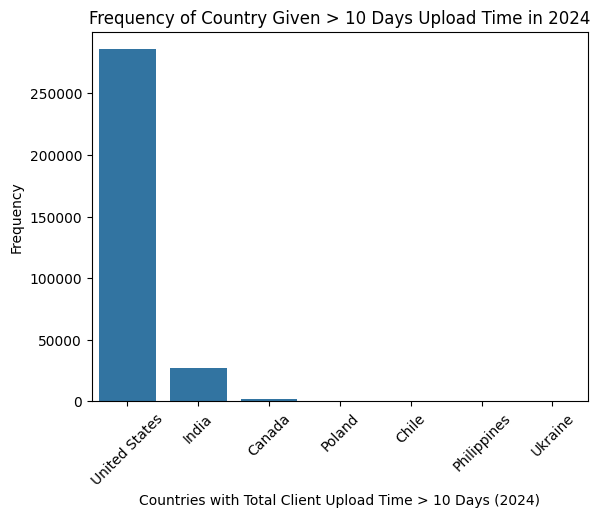

In [38]:
combined_df_2024['client_event_time'] = pd.to_datetime(combined_df_2024['client_event_time'])
combined_df_2024['client_upload_time'] = pd.to_datetime(combined_df_2024['client_upload_time'])
combined_df_2024['time_difference'] = combined_df_2024['client_upload_time'] - combined_df_2024['client_event_time']
combined_df_2024['time_difference_minutes'] = combined_df_2024['time_difference'].dt.total_seconds() / 60

combined_df_2024['time_difference_minutes'].describe()

##

# Exploring those with upload times greater than 10 days (input in minutes)
filtered_df_2024 = combined_df_2024[combined_df_2024['time_difference_minutes'] > 14400]
filtered_df_2024.describe(include='all')

sns.countplot(x='country', data=filtered_df_2024)
plt.xlabel('Countries with Total Client Upload Time > 10 Days (2024)')
plt.ylabel('Frequency')
plt.title('Frequency of Country Given > 10 Days Upload Time in 2024')

# Rotate x-axis labels if they are crowded
plt.xticks(rotation=45)

plt.show()

Specifically examining 2025combined_file.csv

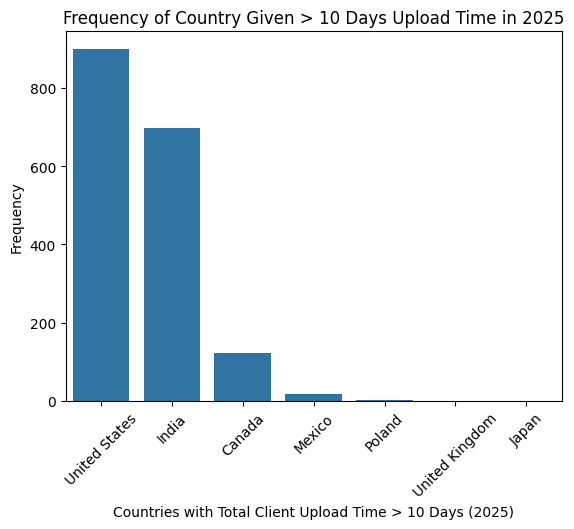

In [39]:
combined_df_2025['client_event_time'] = pd.to_datetime(combined_df_2025['client_event_time'])
combined_df_2025['client_upload_time'] = pd.to_datetime(combined_df_2025['client_upload_time'])
combined_df_2025['time_difference'] = combined_df_2025['client_upload_time'] - combined_df_2025['client_event_time']
combined_df_2025['time_difference_minutes'] = combined_df_2025['time_difference'].dt.total_seconds() / 60

combined_df_2025['time_difference_minutes'].describe()

##

# Exploring those with upload times greater than 10 days (input in minutes)
filtered_df_2025 = combined_df_2025[combined_df_2025['time_difference_minutes'] > 14400]
filtered_df_2025.describe(include='all')

sns.countplot(x='country', data=filtered_df_2025)
plt.xlabel('Countries with Total Client Upload Time > 10 Days (2025)')
plt.ylabel('Frequency')
plt.title('Frequency of Country Given > 10 Days Upload Time in 2025')

# Rotate x-axis labels if they are crowded
plt.xticks(rotation=45)

plt.show()

### Key Insights on the frequency of Country given a greater than 10 days client upload time (2024 vs. 2025)
- A significant drop in metrics on the y-axis due to less data found in 2025
- In 2025, there is more variety in the countries with a greater than 10 days client upload time compared to 2024
- The same countries displayed in both 2024 and 2025 were:
    - United States
    - India
    - Canada
    - Poland 

# Exploratory Data Analysis (EDA) & Insights on Drop-off Points
### Will examine by determining the users who had less events in 2025 compared to 2024

1. To ensure an appropriate timeline, I examined the 2025 dataset and discovered the client_event_time were collected over 207 days. I shortened the 2024 dataset starting from the earliest client_event_time (April 14, 2024) and filtered the data to span over 207 days from that earliest point.

2. I created a list of unique user_ids from the filtered 2024 data set that spans over 207 days, and iterated through that list. During each iteration, I went through the combined 2024 dataset to count the number of times that user_id popped up, and did the same for the 2025 dataset. Those user_ids who showed up less in 2025 compared to 2024, indicates a lower retention rate, as those users are using the platform less than previously.

3. To take out any minimal differences, I filtered the data so that the difference of the number of events from 2024 and 2025 were greater than 50. I also created a new column to display that difference. Several key users are those with significant drop in events, and those users who have 0 events in 2025, as they stopped using the platform (drop-off points).


In [40]:
# since the 2025 data set is over 207 days, I will shorten the 2024 data set to be
##      over 207 days as well, starting from the earliest time
combined_df_2024['client_event_time'] = pd.to_datetime(combined_df_2024['client_event_time'])
start_date = '2024-04-14'
end_date = '2024-11-07'

filtered_df_2024 = combined_df_2024[(combined_df_2024['client_event_time'] >= start_date) & (combined_df_2024['client_event_time'] <= end_date)]

# prints all possible unique user_ids from 2024 dataset over 207 days
users_id_list = filtered_df_2024['user_id'].unique()

# Dictionary to store user_id and row counts for each year
user_row_count = {}

# Iterate over each user_id
for user_id in users_id_list:
    # Get the count of rows for the user_id in filtered_df_2024 and filtered_df_2025
    count_2024 = filtered_df_2024[filtered_df_2024['user_id'] == user_id].shape[0]
    count_2025 = combined_df_2025[combined_df_2025['user_id'] == user_id].shape[0]
    
    # Store the row counts
    user_row_count[user_id] = {'user_id': user_id, '2024': count_2024, '2025': count_2025}

# Convert the dictionary to a DataFrame for easier comparison
row_count_df = pd.DataFrame.from_dict(user_row_count, orient='index')

# Filter out users where the number of rows decreased from 2024 to 2025
filtered_users = row_count_df[(row_count_df['2025'] + 50) <= row_count_df['2024']]
userids_dropoffs = filtered_users['user_id'].unique()

# Create a new column to show the difference between 2024 and 2025
filtered_users['difference'] = row_count_df['2024'] - row_count_df['2025']

/var/folders/rw/2_yr05hd56b1rkq4976bf6w00000gn/T/ipykernel_36549/3407974329.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_users['difference'] = row_count_df['2024'] - row_count_df['2025']


In [41]:
print(filtered_users)

                                                                   user_id  \
125c9087-fbca-4778-a86e-d03332c127fc  125c9087-fbca-4778-a86e-d03332c127fc   
61a2808e-1f12-4e32-b1be-7a62225ade2f  61a2808e-1f12-4e32-b1be-7a62225ade2f   
871ee2be-7f0a-474b-9e33-cc29a4889121  871ee2be-7f0a-474b-9e33-cc29a4889121   
1b98c6bb-b6b9-4b9a-a62f-6a31fb18ada4  1b98c6bb-b6b9-4b9a-a62f-6a31fb18ada4   
a3a47efd-4443-45b2-ae6e-85756b563898  a3a47efd-4443-45b2-ae6e-85756b563898   
...                                                                    ...   
0fa9ac2a-c33f-492c-ba5b-8b4933fc1006  0fa9ac2a-c33f-492c-ba5b-8b4933fc1006   
d01e89e5-f6b1-4737-bee0-eafd00679b82  d01e89e5-f6b1-4737-bee0-eafd00679b82   
d7088c42-2c28-d1d4-f0c7-352e7b8611ec  d7088c42-2c28-d1d4-f0c7-352e7b8611ec   
1adda23e-0432-434f-9a66-994feceae381  1adda23e-0432-434f-9a66-994feceae381   
bc372c02-8133-467c-8964-6ea649cd5ca5  bc372c02-8133-467c-8964-6ea649cd5ca5   

                                      2024  2025  difference  


## Examining drop-off points
Examining one user_id = '61a2808e-1f12-4e32-b1be-7a62225ade2f' where there is a significant drop in the amount of activity, from 5841 events in 2024 to 0 in 2025.

After examining several columns, the user_id added the business unit: 'UA Pool' halfway through. As well, there were more uses of session_end event as time went on. The uses of session_end were 0 in the months April-June 2024, and gradually increased each month afterwards. Due to an increase in session_end events, the duration between client_event_time and client_upload_time have a significant spike between any other events. Thus, I can infer that as the user began to make use of session_end more often, they realized the loading time was much longer than the usualy events with faster times.

As a result, the user stopped using Federato's platform and cannot be found in the 2025 dataset.

In [42]:
# Dictionary to store user_id
dropoff_users_df_2024 = filtered_df_2024[filtered_df_2024['user_id'].isin(userids_dropoffs)]
dropoff_users_df_2025 = combined_df_2025[combined_df_2025['user_id'].isin(userids_dropoffs)]

# Investigate user_id = f9663192-75be-44a6-ad1a-bf4db4a77074
user_2024 = dropoff_users_df_2024[dropoff_users_df_2024['user_id'] == '61a2808e-1f12-4e32-b1be-7a62225ade2f']
user_2025 = dropoff_users_df_2025[dropoff_users_df_2025['user_id'] == '61a2808e-1f12-4e32-b1be-7a62225ade2f']

## Stickiness over a 28-day period
To measure stickiness, we must determine the time spent per day on the Federato platforn across all sessions over a 28-day period. Using the dates on client_event_time, the earliest date is April 14, 2024, and the latest is January 28, 2025. Which in total displays 10 28-day periods.

I will examine the first 28-day period: April 14, 2024 - May 12, 2024

In [43]:
start_date = pd.to_datetime('2024-04-14')
end_date = pd.to_datetime('2024-05-12')

first_period_2024 = combined_df_2024[(combined_df_2024['client_event_time'] >= start_date) & (combined_df_2024['client_event_time'] <= end_date)]

# Number of users in first period
first_period_2024['user_id'].nunique() # 456 users




# Initialize an empty list to store the total time spent per day
total_time_spent_per_day = []

# Loop over each day in the date range (28 days)
for i in range(28):
    # Filter the DataFrame for the current date
    filtered_data = combined_df_2024[(combined_df_2024['client_event_time'].dt.date >= start_date.date()) & 
                                     (combined_df_2024['client_event_time'].dt.date < (start_date + pd.Timedelta(days=1)).date())]
    
    # Sum the 'total_time_spent_minutes' for that date
    total_time = filtered_data['time_difference_minutes'].sum()
    
    # Append the total time spent to the list
    total_time_spent_per_day.append(total_time)
    
    # Increment the date by 1 day for the next iteration
    start_date += pd.Timedelta(days=1)
    
# Print the results
for date, time_spent in zip(pd.date_range(start=start_date, end=end_date), total_time_spent_per_day):
    print(f"Date: {date.date()}, Total Time Spent: {time_spent} minutes")

print(total_time_spent_per_day)

Date: 2024-05-12, Total Time Spent: 4.011516666666666 minutes
[np.float64(4.011516666666666), np.float64(0.23516666666666666), np.float64(0.2913), np.float64(1.4894333333333334), np.float64(7.33135), np.float64(0.0), np.float64(1.4895666666666667), np.float64(0.0), np.float64(-4.92413333333333), np.float64(8896294.647550002), np.float64(4.92765), np.float64(7.886000000000003), np.float64(6.5043500000000005), np.float64(897.3173166666666), np.float64(2.96475), np.float64(992.0177500000001), np.float64(23.148699999999998), np.float64(0.0), np.float64(0.0), np.float64(-7.3694500000000005), np.float64(2.750166666666667), np.float64(1.7894166666666667), np.float64(36.04528333333333), np.float64(124.08306666666664), np.float64(0.0), np.float64(2.896216666666666), np.float64(4425.6402333333335), np.float64(8.345133333333333)]


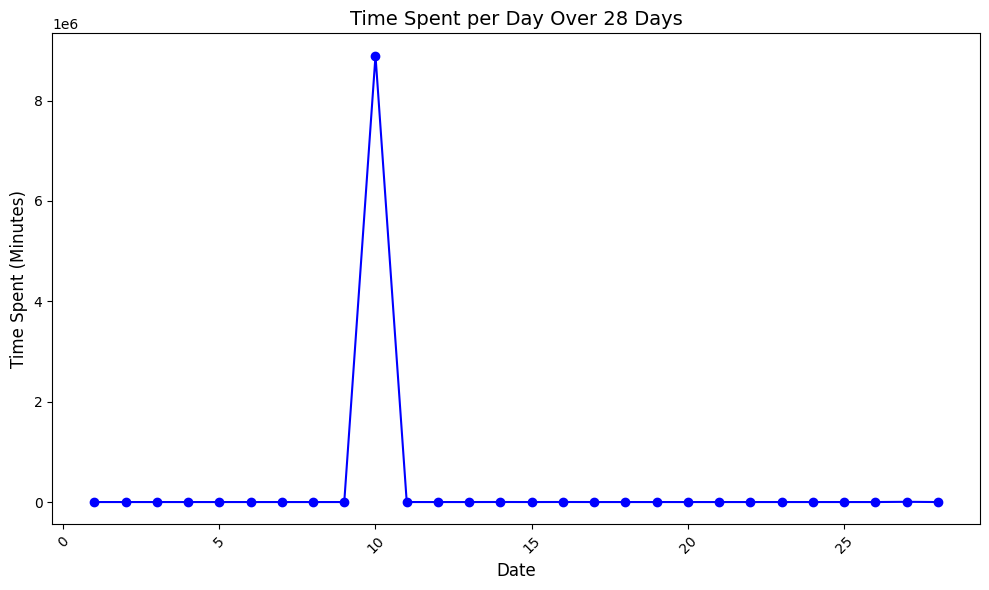

In [44]:
## Plotting
# Plot the time spent per day over the 28-day period
plt.figure(figsize=(10, 6))
plt.plot([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28], total_time_spent_per_day, marker='o', linestyle='-', color='b')

# Adding title and labels
plt.title('Time Spent per Day Over 28 Days', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Time Spent (Minutes)', fontsize=12)

# Formatting the x-axis for better readability (showing date as YYYY-MM-DD)
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()
plt.show()

## Without the Outlier from the 10th day
We will investigate the 11th-28th days

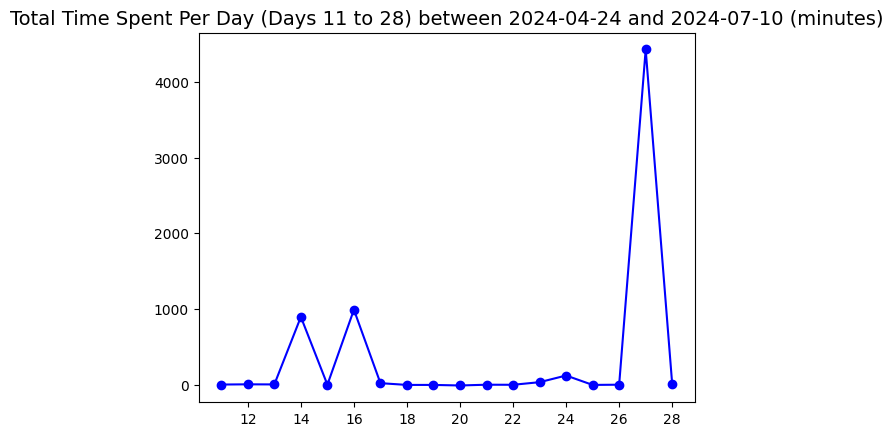

In [45]:
plt.plot([11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28], total_time_spent_per_day[10:], marker='o', linestyle='-', color='b')
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.title("Total Time Spent Per Day (Days 11 to 28) between 2024-04-24 and 2024-07-10 (minutes)", fontsize=14)
plt.show()

## Examining the Users who return within a day (28-day period in 2024)

In [46]:
# Convert timestamp to datetime
first_period_2024['timestamp'] = pd.to_datetime(first_period_2024['client_event_time'])

# Sort by user and timestamp
first_period_2024 = first_period_2024.sort_values(by=['user_id', 'client_event_time'])

# Calculate time difference between visits for each user
first_period_2024['time_diff'] = first_period_2024.groupby('user_id')['client_event_time'].diff()

# Define the threshold for "return" (e.g., 1 day)
return_threshold = pd.Timedelta(days=1)

# Apply the comparison element-wise
first_period_2024['is_return'] = first_period_2024['time_diff'].apply(lambda x: x <= return_threshold if pd.notnull(x) else False)

# Display the dataframe with return status
print(first_period_2024)

                                  $insert_id  amplitude_id     app       city  \
660339  5019b94b-e1fc-4ff8-8ad3-e9bfd1c5d632  857540567657  591532   New York   
660340  d55b2352-7edc-4135-9e79-3ea32286bf1e  857540567657  591532   New York   
660341  0c121ebf-4e19-427c-a2b1-6e2529df7187  857540567657  591532   New York   
660342  7cd24445-ab8f-484a-b560-8d189d7de9ac  857540567657  591532   New York   
660343  4e33af74-2cfd-44cd-ab9b-b91732b0aba9  857540567657  591532   New York   
...                                      ...           ...     ...        ...   
580851  9d38dd43-76d6-4112-8dbd-9d61e81fd29d  891686495132  591532    Chicago   
522250  a165a972-31ec-4dfb-b4b4-b118365aba87  892725872991  591532   Boardman   
581390  fd1932e8-5a92-4cd0-95ee-cfeed02be675  893717073725  591532  Maryville   
602627  f0146dc8-2787-4eb8-986b-135de5b9ebb6  893617884867  591532   Boardman   
617649  8418806c-56b1-4db2-b33f-59cf509219ba  894506692727  591532   Boardman   

             client_event_t

/var/folders/rw/2_yr05hd56b1rkq4976bf6w00000gn/T/ipykernel_36549/470091561.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_period_2024['timestamp'] = pd.to_datetime(first_period_2024['client_event_time'])


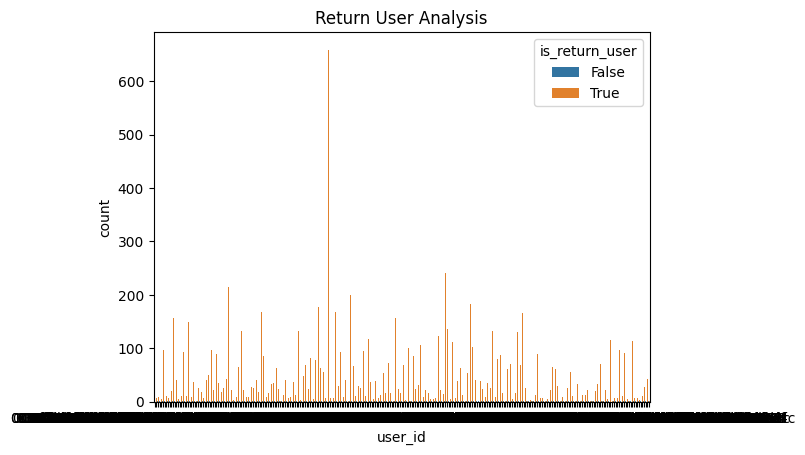

In [47]:
# Find the first interaction for each user
first_interaction = first_period_2024.groupby('user_id')['client_event_time'].min().reset_index()
first_interaction.columns = ['user_id', 'first_timestamp']

# Merge with the original data
df_with_first = pd.merge(first_period_2024, first_interaction, on='user_id')

# Calculate return time (difference between visit and first interaction)
df_with_first['time_from_first'] = df_with_first['client_event_time'] - df_with_first['first_timestamp']

# Flag return users (if time_from_first > 0 means return visit)
df_with_first['is_return_user'] = df_with_first['time_from_first'] > pd.Timedelta(0)

# Plot the return rate by user
sns.countplot(data=df_with_first, x='user_id', hue='is_return_user')
plt.title('Return User Analysis')
plt.show()

# Examining the Cohort Analysis per Day of the 28-day Period (2024)

In [48]:
# Define cohorts based on the first registration date (e.g., by month)
df_with_first['cohort'] = df_with_first['first_timestamp'].dt.to_period('D')

# Group by cohort and calculate return rates
cohort_analysis = df_with_first.groupby(['cohort', 'is_return_user']).size().unstack(fill_value=0)

# Calculate return rate for each cohort
cohort_analysis['return_rate'] = cohort_analysis[True] / (cohort_analysis[True] + cohort_analysis[False])

# Display cohort analysis
print(cohort_analysis)

is_return_user  False  True  return_rate
cohort                                  
2024-04-14          2   297     0.993311
2024-04-16          2    34     0.944444
2024-04-17          2    65     0.970149
2024-04-18         31   516     0.943327
2024-04-20          3   494     0.993964
2024-04-22         80  4966     0.984146
2024-04-24          6   201     0.971014
2024-04-25         45  1556     0.971893
2024-04-26          3   217     0.986364
2024-04-29         66  3257     0.980138
2024-04-30         21  1150     0.982067
2024-05-03          2    29     0.935484
2024-05-06         13   231     0.946721
2024-05-07         17   187     0.916667
2024-05-10          3    11     0.785714
2024-05-11          1   183     0.994565


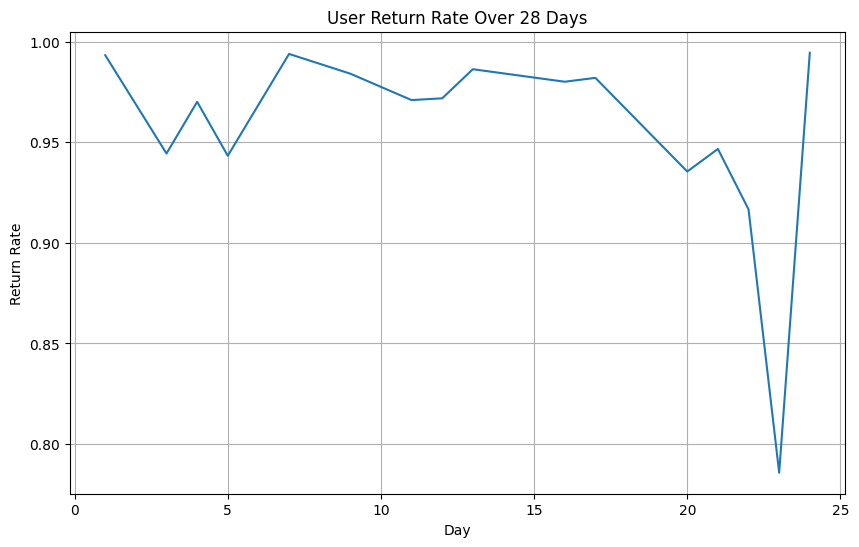

In [49]:
# Plot return rate over the 28-day period
plt.figure(figsize=(10, 6))
sns.lineplot(data=cohort_analysis, x=[1,3,4,5,7,9,11,12,13,16,17,20,21,22,23,24], y='return_rate')
plt.title('User Return Rate Over 28 Days')
plt.xlabel('Day')
plt.ylabel('Return Rate')
plt.grid(True)
plt.show()

### Key Insights on Stickiness in 2024
- A significant drop in user return rate from the 20th day to the 23rd day which a spike follows shortly after
- A drop right at the beginning after an attempt from a user, which could be a result of troubleshooting issues and getting familiar with the software